# Panikos Christou Internship notebook

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import networkx as nx
import numpy as np
from sklearn.utils import shuffle
import nltk
from nltk.tokenize import TweetTokenizer
import random
from operator import itemgetter
import itertools
import copy
from feature_selector import FeatureSelector
import numpy as np

## Opening the dataset

In [2]:
training_data_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "trainingdata-all-annotations.txt",
)
test_data_a_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "testdata-taskA-all-annotations.txt",
)
test_data_b_location = os.path.join(
    "D:/affiliated_acounts",
    "Data",
    "stance-data",
    "data-all-annotations",
    "testdata-taskB-all-annotations.txt",
)
# todo test data aswell
file1 = open(training_data_location, "r")
file2 = open(test_data_a_location, "r")
file3 = open(test_data_b_location, "r")

In [3]:
dataset = pd.read_csv(file1, sep="\t")
dataset.append(pd.read_csv(file2, sep="\t"))
dataset.append(pd.read_csv(file3, sep="\t"))
# append here
print(dataset.head(2))
dataset.count()

    ID   Target                                              Tweet   Stance  \
0  101  Atheism  dear lord thank u for all of ur blessings forg...  AGAINST   
1  102  Atheism  Blessed are the peacemakers, for they shall be...  AGAINST   

  Opinion towards Sentiment  
0           OTHER  POSITIVE  
1           OTHER  POSITIVE  


ID                 2814
Target             2814
Tweet              2814
Stance             2814
Opinion towards    2814
Sentiment          2814
dtype: int64

## Helper functions to help later with extracting data

In [4]:
def get_data_of_target(target):
    return dataset[dataset["Target"] == target]


def get_data_of_target_form_dataset(target, dataset):
    return dataset[dataset["Target"] == target]


print(get_data_of_target("Hillary Clinton").head())
print()
print(len(get_data_of_target("Hillary Clinton")))


def get_mentions(tweet):
    found = []
    matches = re.findall(regex_mention, tweet)
    if matches:
        found = [("@" + match) for match in matches]
    return found

        ID           Target  \
1572  1673  Hillary Clinton   
1573  1674  Hillary Clinton   
1574  1675  Hillary Clinton   
1575  1676  Hillary Clinton   
1576  1677  Hillary Clinton   

                                                  Tweet   Stance  \
1572  RT @GunnJessica: Because I want young American...    FAVOR   
1573  @Chris_1791 @newsbusters 2 years ago #Hillary ...  AGAINST   
1574  @dnewhauser take that, Marco Rubio. @GOP canno...     NONE   
1575  @StateDept @AmbCathyRussell @AdamSmith_USA @Hi...    FAVOR   
1576  Lets remember #dickcheney is an unindicted war...     NONE   

     Opinion towards Sentiment  
1572           OTHER  POSITIVE  
1573          TARGET  NEGATIVE  
1574           OTHER  NEGATIVE  
1575          TARGET  POSITIVE  
1576           OTHER  NEGATIVE  

639


## Regex to extract all mentions and hshtags from a tweet

In [5]:
regex_mention = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_.]))@([A-Za-z]+[A-Za-z0-9-_]+)")
regex_hashtag = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_.]))#([A-Za-z]+[A-Za-z0-9-_]+)")

## Graph making skills testing ground which will help later

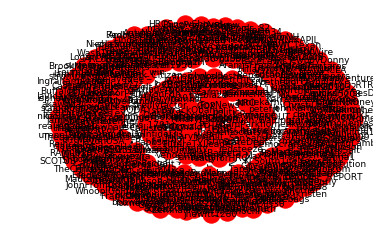

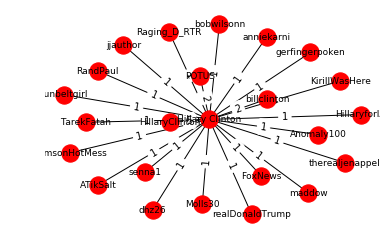

In [6]:
def create_a_graph_of_mentions_no_data_specified(
    target, print_it=False, percentage_of_data=0
):
    G = nx.Graph()
    if not percentage_of_data:
        data = get_data_of_target(target)
    else:
        data = get_data_of_target(target)
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        matches = re.findall(regex_mention, tweet)
        if matches:
            for match in matches:
                if G.has_edge(target, match):
                    G.add_edge(target, match, weight=G[target][match]["weight"] + 1)
                else:
                    G.add_edge(target, match, weight=1)
    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


target = "Hillary Clinton"
G1 = create_a_graph_of_mentions_no_data_specified(target, print_it=True)
G2 = create_a_graph_of_mentions_no_data_specified(
    target, print_it=True, percentage_of_data=0.05
)

## Testing on how sort the edges and the the centrality of nodes of the graph. We will explain later what they are and why they are needed.

In [7]:
def sorted_centrality(G1):
    centrality = nx.betweenness_centrality(G1)
    sorted_by_centrality = sorted(centrality, key=lambda x: centrality[x], reverse=True)
    sorted_by_centrality_with_values = [
        [i, centrality[i]] for i in sorted_by_centrality
    ]
    return sorted_by_centrality_with_values


print(sorted_centrality(G1)[:5])

[['Hillary Clinton', 1.0], ['GunnJessica', 0.0], ['Chris_1791', 0.0], ['newsbusters', 0.0], ['dnewhauser', 0.0]]


In [8]:
def sorted_edges(G1):
    sorted_edges = sorted(
        G1.edges(data=True), key=lambda t: t[2].get("weight", 1), reverse=True
    )
    return sorted_edges


print(sorted_edges(G1)[:5])

[('Hillary Clinton', 'HillaryClinton', {'weight': 118}), ('Hillary Clinton', 'POTUS', {'weight': 15}), ('Hillary Clinton', 'billclinton', {'weight': 14}), ('Hillary Clinton', 'GOP', {'weight': 8}), ('Hillary Clinton', 'BarackObama', {'weight': 8})]


# Manualy did some data

## Code that reads manual data and saves them to a pandas dict of lists, will be used later

In [9]:
manual_data = pd.read_csv("manual_data_updated.csv", index_col=0)
print(manual_data.head())
print("\n\n")
data = {"target": [], "account": [], "affiliated": []}
for index, row in manual_data.iterrows():
    data["target"].append(row[0])
    data["account"].append(row[1])
    data["affiliated"].append(row[2])
print(len(data["target"]))

              target         account  affiliated
0    Hillary Clinton  HillaryClinton        True
411  Hillary Clinton      JW4Hillary        True
125  Hillary Clinton        DNCWomen        True
164  Hillary Clinton   ClintonGlobal        True
300  Hillary Clinton    HillaryforSC        True



363



### Also a function that returns all the mentions in the dataset

In [10]:
def get_mentions_from_tweets_from_dataset(target):
    all_mentions = []
    Hillary_tweets = get_data_of_target(target)["Tweet"]
    for tweet in Hillary_tweets:
        mentions = get_mentions(tweet)
        if mentions:
            for i in mentions:
                all_mentions.append(i[1:])  # no hashtag
    return all_mentions

## I have manually went through the datasset with the below code, And if uncommented it will recheck the meentions and find the new entions and ask ou for those ... if a mention from the dataset wasnt manually checked then it asks  the user to fill it. When you exit it updates the csv file
### uncomment it if you want to add users to dasates and manualy check them

In [11]:
# df = pd.read_csv("manual_data.csv",index_col = 0)
# df = df.sort_values(["affiliated",], ascending = (False))
# df = df.drop_duplicates(subset='account', keep="first")

# print(df)
# print(len(df))

# all_mentions = get_mentions_from_tweets_from_dataset('Hillary Clinton')

# for account in all_mentions:
#     if account in data['account']:continue
#     is_affiliated = input(('Is ',"Hillary Clinton", " affiliated with ",account," ?"))
#     if  is_affiliated == 'y' :
#         data['target'].append(account[0])
#         data['account'].append(account[1])
#         data['affiliated'].append(True)
#     else:
#         if  is_affiliated == 'exit': break
#         data['target'].append(account[0])
#         data['account'].append(account[1])
#         data['affiliated'].append(False)
# df = pd.DataFrame(data=data)
# df.to_csv("manual_data_updated.csv")
# print(len(data['target']))
# print(data)

## NLP proccessing testing ground

In [12]:
tknzr = TweetTokenizer()
Hillary_tweets = get_data_of_target("Hillary Clinton")["Tweet"]
tokenized_tweets = [tknzr.tokenize(t) for t in Hillary_tweets]
print(tokenized_tweets[:1])

[['RT', '@GunnJessica', ':', 'Because', 'I', 'want', 'young', 'American', 'women', 'to', 'be', 'able', 'to', 'be', 'proud', 'of', 'the', '1st', 'woman', 'president', '#SemST']]


In [13]:
pos_tweets = [nltk.pos_tag(tweet) for tweet in tokenized_tweets]
pos_tweets[11]

[("Didn't", 'NNP'),
 ('realize', 'VB'),
 ('Bob', 'NNP'),
 ('Dole', 'NNP'),
 ('was', 'VBD'),
 ('mentioned', 'VBN'),
 ('in', 'IN'),
 ("Tupac's", 'NNP'),
 ('"', 'NNP'),
 ('How', 'NNP'),
 ('do', 'VBP'),
 ('u', 'JJ'),
 ('want', 'VB'),
 ('it', 'PRP'),
 ('"', 'JJ'),
 ('#YesterdaysLeaders', 'NNS'),
 ('#SemST', 'VBP')]

## Now i know how ro chunch sentences an extract named entities to help with the below

In [14]:
# Create the named entity chunks: chunked_sentences
chunked_tweets = nltk.ne_chunk_sents(pos_tweets, binary=True)
NERS = []
for chunked_tweet in chunked_tweets:
    for word in chunked_tweet:
        if hasattr(word, "label") and word.label() == "NE":
            NERS.append(word)
NERS[:15]

[Tree('NE', [('RT', 'NNP')]),
 Tree('NE', [('American', 'JJ')]),
 Tree('NE', [('Marco', 'NNP'), ('Rubio', 'NNP')]),
 Tree('NE', [('Latino', 'NNP')]),
 Tree('NE', [('Human', 'NNP')]),
 Tree('NE', [('Clinton', 'NNP')]),
 Tree('NE', [('Bill', 'NNP'), ('Clinton', 'NNP')]),
 Tree('NE', [('Bob', 'NNP'), ('Dole', 'NNP')]),
 Tree('NE', [('Oval', 'NNP'), ('Office', 'NNP')]),
 Tree('NE', [('SOS', 'NNP')]),
 Tree('NE', [('RT', 'NNP')]),
 Tree('NE', [('SEXIST', 'NNP')]),
 Tree('NE', [('Low', 'JJ')]),
 Tree('NE', [('Iraq', 'NNP')]),
 Tree('NE', [('Does', 'NNP')])]

# Co-occurence graph V2.0 using Named entities to create a graph instead of mentions

## Below we create a set of all sigle word entities

In [15]:
list_of_list_entities = [i[:] for i in NERS]
# print(list_of_list_entities[:5])
temp = ""
entities = []
for list_entities in list_of_list_entities:
    temp = ""
    for string in list_entities:
        temp = temp + string[0] + " "
    entities.append(temp[:-1])
set_entities = set(entities)
print(random.sample(set_entities, 5))

['BIG', 'Rand Paul', 'Clintons', 'Iowa', 'Donald']


## Updated the above to a function that now also recognizes multi word entities and tested it. 

In [16]:
tknzr = TweetTokenizer()
# lets make it a function that takes in a sentence and prints out as above all ners in it
def get_entities(tweet):
    pos_test = nltk.pos_tag(tknzr.tokenize(tweet))
    #    print(pos_test)
    chunked_tweet = nltk.ne_chunk(pos_test)
    #    print(chunked_tweet)
    NERS = []
    for word in chunked_tweet:
        if hasattr(word, "label"):
            NERS.append(word)
    #    print(NERS)
    temp = ""
    entities = []
    for list_entities in NERS:
        temp = ""
        for string in list_entities:
            temp = temp + string[0] + " "
        entities.append(temp[:-1])
    #    print(entities)
    return entities


string_test = "Didn't realize Hillary Clinton with Bob Dole was mentioned in Tupac's \"How do u want it\" #YesterdaysLeaders"

get_entities(string_test)

['Hillary Clinton', 'Bob Dole']

### Make them lowercase to avoid "Hillary" being different from "hillary"

In [17]:
entities_lower = [i.lower() for i in entities]
entities_lower[:5]
set_entities = set(entities_lower)
set_entities

{'#hillaryclinton',
 '@autumnnalston',
 '@hillaryclinton',
 '@hillaryclinton awesome',
 '@hillaryclinton did',
 '@hillaryclinton hahahaha',
 "@hillaryclinton i'd",
 '@hillaryclinton pretty',
 '@hillaryclinton r',
 '@hillaryclinton so',
 '@hillaryclinton stop',
 '@hillaryclinton will',
 'aaron hernandez',
 'aca',
 'adolph hitler',
 'again',
 'al qaeda',
 'all',
 'always',
 'amb stevens',
 'ambassador',
 'america',
 'america weekend',
 'american',
 'americans',
 'americans welfare checks',
 'andrew fastow',
 'apple',
 'australia',
 'back',
 'baltimore',
 'benghazi',
 'bern',
 'bernie',
 'bernie sanders',
 'bethesda',
 'big',
 'bill',
 'bill clinton',
 'bill clinton decided',
 'bin laden',
 'bingo',
 'black',
 'blacks',
 'bliss studio',
 'bob dole',
 'bogus',
 'bosnia',
 'brew house',
 'broke',
 'bush',
 'button',
 'cabinet secretaries',
 'california',
 'campaign slogan',
 'canada',
 'cancer',
 'cant',
 'care',
 'change',
 'chelsea',
 'chester',
 'chicago',
 'china',
 'chipotle',
 'chris 

# Now that we practised finding NERS lets make the real graph
## functions that create graph for use later

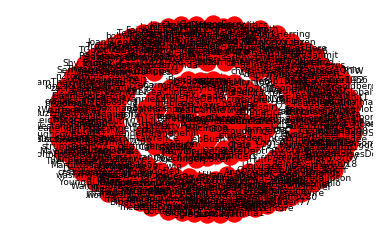

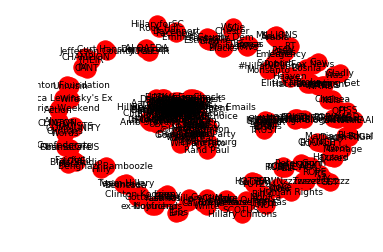

In [18]:
def create_a_graph_of_number_of_times_user_is_tweeted(
    target, dataset, print_it=False, percentage_of_data=0, regex=regex_mention
):
    G = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    if percentage_of_data:
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        matches = re.findall(regex, tweet)
        if matches:
            for match in matches:
                if G.has_edge(target, match):
                    G.add_edge(target, match, weight=G[target][match]["weight"] + 1)
                else:
                    G.add_edge(target, match, weight=1)
    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


G_mentions = create_a_graph_of_number_of_times_user_is_tweeted(
    "Hillary Clinton", dataset, True
)


def create_a_graph_of_entities(target, dataset, print_it=False, percentage_of_data=0):
    G = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    if percentage_of_data:
        data = data.sample(n=int(percentage_of_data * len(data["Tweet"])))
    for tweet in data["Tweet"]:
        entities = get_entities(tweet)
        if entities:
            #         for entity in entities:
            for pair in itertools.combinations(entities, 2):
                #             clone = entities.copy()
                #             clone.remove(entity)
                #             for entity_secondary in clone:
                entity = pair[0]
                entity_secondary = pair[1]
                if G.has_edge(entity, entity_secondary):
                    G.add_edge(
                        entity,
                        entity_secondary,
                        weight=G[entity][entity_secondary]["weight"] + 1,
                    )
                else:
                    G.add_edge(entity, entity_secondary, weight=1)

    if print_it:
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
        nx.draw(G, pos)
        labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
    return G


G_entities = create_a_graph_of_entities("Hillary Clinton", dataset, True)

## The previous functions now new with all the centrality data

In [19]:
##Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
def sorted_centrality(graph):
    centrality = nx.betweenness_centrality(graph)
    
    sorted_by_centrality = sorted(centrality, key=lambda x: centrality[x], reverse=True)
    sorted_by_centrality_with_values = [
        [i, centrality[i]] for i in sorted_by_centrality
    ]
    return sorted_by_centrality_with_values


sorted_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.0],
 ['Chris_1791', 0.0],
 ['newsbusters', 0.0],
 ['dnewhauser', 0.0]]

In [20]:
def sorted_edge_centrality(graph):
    edge_centrality = nx.edge_betweenness_centrality(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_edge_centrality(G_mentions)[:5]

[[('Hillary Clinton', 'GunnJessica'), 0.005494505494505495],
 [('Hillary Clinton', 'Chris_1791'), 0.005494505494505495],
 [('Hillary Clinton', 'newsbusters'), 0.005494505494505495],
 [('Hillary Clinton', 'dnewhauser'), 0.005494505494505495],
 [('Hillary Clinton', 'GOP'), 0.005494505494505495]]

In [21]:
# Closeness centrality 1 of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.
def sorted_closeness_centrality(graph):
    edge_centrality = nx.closeness_centrality(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_closeness_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.5006896551724138],
 ['Chris_1791', 0.5006896551724138],
 ['newsbusters', 0.5006896551724138],
 ['dnewhauser', 0.5006896551724138]]

In [22]:
def sorted_pagerank_centrality(graph):
    edge_centrality = nx.pagerank(graph)
    sorted_by_edge_centrality = sorted(
        edge_centrality, key=lambda x: edge_centrality[x], reverse=True
    )
    sorted_by_centrality_with_values = [
        [i, edge_centrality[i]] for i in sorted_by_edge_centrality
    ]
    return sorted_by_centrality_with_values


sorted_pagerank_centrality(G_mentions)[:5]

[['Hillary Clinton', 0.45976520573668056],
 ['HillaryClinton', 0.07573289199165942],
 ['POTUS', 0.009986766396779204],
 ['billclinton', 0.009348454497799785],
 ['GOP', 0.005518583103923268]]

In [23]:
# degree_centrality which is defined as the number of links incident upon a node
def sorted_by_degree_centrality(graph):
    degree_centrality = nx.degree_centrality(graph)
    sorted_by_degree_centrality = sorted(
        degree_centrality, key=lambda x: degree_centrality[x], reverse=True
    )
    sorted_by_degree_centrality_with_values = [
        [i, degree_centrality[i]] for i in sorted_by_degree_centrality
    ]
    return sorted_by_degree_centrality_with_values


sorted_by_degree_centrality(G_mentions)[:5]

[['Hillary Clinton', 1.0],
 ['GunnJessica', 0.0027548209366391185],
 ['Chris_1791', 0.0027548209366391185],
 ['newsbusters', 0.0027548209366391185],
 ['dnewhauser', 0.0027548209366391185]]

In [24]:
# Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network.
# It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes
# contribute more to the score of the node in question than equal connections to low-scoring nodes.
def sorted_by_eigenvector_centrality(graph):
    try:
        eigenvector_centrality = nx.eigenvector_centrality(graph)
        sorted_by_eigenvector_centrality = sorted(
            eigenvector_centrality,
            key=lambda x: eigenvector_centrality[x],
            reverse=True,
        )
        sorted_by_eigenvector_centrality_with_values = [
            [i, eigenvector_centrality[i]] for i in sorted_by_eigenvector_centrality
        ]
        return sorted_by_eigenvector_centrality_with_values
    except nx.exception.PowerIterationFailedConvergence:
        return None


temp = sorted_by_eigenvector_centrality(G_mentions)
if temp:
    print(temp[:5])

### Helper function to help with getting the hashtags

In [25]:
def get_list_of_hashtags(tweet):
    found = []
    matches = re.findall(regex_hashtag, tweet)
    if matches:
        found = [("#" + match) for match in matches]
    return found

### I will create a dictionary which will map the pair of entities i.e. @hillaryclinton and @barackobama with another dictionary with a list of the tweets, a list of their respective sentiments, the number of hashtags, a list of the hashtags, number of user mentions, a list of usermentions and if its a retweet if that tweet has them both together in its text.

In [26]:
dict_of_pairs = {}
data_of_Hillary = get_data_of_target("Hillary Clinton")
print(len(data_of_Hillary))
mentions_with_more_than_1_mention = 0
for index, row in data_of_Hillary.iterrows():
    mentions = get_mentions(row["Tweet"])
    if len(mentions) > 1:
        mentions_with_more_than_1_mention += 1
        hashtags = get_list_of_hashtags(row["Tweet"])
        for pair in itertools.combinations(mentions, 2):
            mention = pair[0]
            mention_secondary = pair[1]
            key = (mention, mention_secondary)
            if key in dict_of_pairs:  # if pair already exists
                dict_of_pairs[key]["list_of_tweets"].append(row["Tweet"])
                dict_of_pairs[key]["list_of_sentiments"].append(row["Sentiment"])
                dict_of_pairs[key]["list_of_Stances"].append(row["Stance"])
                dict_of_pairs[key]["list_of_Opinion_Towards"].append(
                    row["Opinion towards"]
                )
                dict_of_pairs[key]["list_of_list_of_user_mentions"].append(mentions)
                dict_of_pairs[key]["list_of_num_hashtags"].append(len(hashtags))
                dict_of_pairs[key]["list_of_list_of_the_hashtags"].append(hashtags)
                dict_of_pairs[key]["number_of_the_user_mentions"].append(len(mentions))
                dict_of_pairs[key]["retweet"].append(
                    True if row["Tweet"][0:2] == "RT" else False
                )

            else:  # if pair does not already exists
                dict_of_pairs[key] = {
                    "list_of_tweets": [row["Tweet"]],
                    "list_of_sentiments": [row["Sentiment"]],
                    "list_of_Stances": [row["Stance"]],
                    "list_of_Opinion_Towards": [row["Opinion towards"]],
                    "list_of_num_hashtags": [len(hashtags)],
                    "list_of_list_of_the_hashtags": [hashtags],
                    "number_of_the_user_mentions": [len(mentions)],
                    "list_of_list_of_user_mentions": [mentions],
                    "retweet": [True if row["Tweet"][0:2] == "RT" else False],
                }
# matplotlib everything to show better and compare with mine vs data
# mine affilited finnd in here and compare with the not
# print(dict_of_pairs)
nums = dict_of_pairs.items()
print(mentions_with_more_than_1_mention)
print(len(nums))
sorted_nums = sorted(nums, key=lambda x: len(x[1]["list_of_tweets"]), reverse=True)
list_nums = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n " for i in sorted_nums
]
for i in list_nums:
    print(i)
    print()

639
137
393
(('@HillaryClinton', '@billclinton'), {'list_of_tweets': ['@Network_Citizen @ProudInfidel33 @YoungBLKRepub "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@sunbeltgirl @9975Ts @bobwilsonn "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #StopHillary2016 #SemST', '@WoodenThreat @ProudInfidel33 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@kin2souls @sunbeltgirl @ChristiChat "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@RedStateJake "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@Babbsgirl2 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@ResistTyranny "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHilla

## Getting Hillarys  connections sorted to check up if we are doing ok

In [27]:
hillary_with_other = []
for i in sorted_nums:
    if i[0][0] == "@HillaryClinton" or i[0][1] == "@HillaryClinton":
        hillary_with_other.append(i)
hillary_with_other_printable = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n "
    for i in hillary_with_other
]
print(len(hillary_with_other))
for i in hillary_with_other_printable:
    print(i)
    print()

70
(('@HillaryClinton', '@billclinton'), {'list_of_tweets': ['@Network_Citizen @ProudInfidel33 @YoungBLKRepub "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@sunbeltgirl @9975Ts @bobwilsonn "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #StopHillary2016 #SemST', '@WoodenThreat @ProudInfidel33 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@kin2souls @sunbeltgirl @ChristiChat "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #SemST', '@RedStateJake "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@Babbsgirl2 "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #SemST', '@ResistTyranny "@HillaryClinton can\'t even manage @billclinton and she wants to be @POTUS" #lol #WakeUpAmerica #StopHillary2016 #S

## Now lets create a graph of mapping the mentions aswell

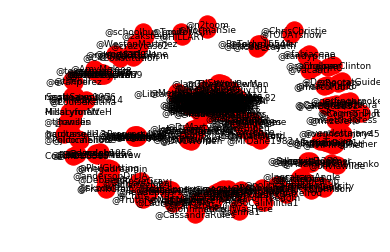

In [28]:
def create_a_graph_of_sum_of_users_being_together_in_a_tweet(target, print_it=False):
    mention_graph = nx.Graph()
    data = get_data_of_target_form_dataset(target, dataset)
    for tweet in data["Tweet"]:
        graph_mentions = get_mentions(tweet)
        if graph_mentions:
            #         for entity in entities:
            for pair in itertools.combinations(graph_mentions, 2):
                #             clone = entities.copy()
                #             clone.remove(entity)
                #             for entity_secondary in clone:
                entity = pair[0]
                entity_secondary = pair[1]
                if mention_graph.has_edge(entity, entity_secondary):
                    mention_graph.add_edge(
                        entity,
                        entity_secondary,
                        weight=mention_graph[entity][entity_secondary]["weight"] + 1,
                    )
                else:
                    mention_graph.add_edge(entity, entity_secondary, weight=1)
    if print_it:
        pos = nx.spring_layout(mention_graph)  # positions for all nodes
        nx.draw_networkx_labels(
            mention_graph, pos, font_size=9, font_family="sans-serif"
        )
        nx.draw(mention_graph, pos)
        labels = nx.get_edge_attributes(mention_graph, "weight")
        nx.draw_networkx_edge_labels(mention_graph, pos, edge_labels=labels)
        plt.show()
    return mention_graph


target = "Hillary Clinton"
mention_graph = create_a_graph_of_sum_of_users_being_together_in_a_tweet(target, True)

In [29]:
sorted_pagerank_centrality_mention_graph = sorted_pagerank_centrality(mention_graph)
print(sorted_pagerank_centrality_mention_graph[:20])

[['@HillaryClinton', 0.06699427264095244], ['@billclinton', 0.02618198930515646], ['@POTUS', 0.02618198930515646], ['@BarackObama', 0.01071066596815459], ['@BernieSanders', 0.008420435738953432], ['@realDonaldTrump', 0.006875263248932662], ['@DrMartyFox', 0.006475684396055533], ['@danmericaCNN', 0.006293896584240578], ['@CarmineZozzora', 0.0062451744569152106], ['@TheDemocrats', 0.0062109846868326195], ['@HillaryforIA', 0.006195130658460316], ['@pamnsc', 0.00618795050295642], ['@politico', 0.006073466256905472], ['@Lawrence', 0.005938337613827025], ['@Callisto1947', 0.005878959534105286], ['@StateDept', 0.005857075756494431], ['@joanwalsh', 0.005723716149607982], ['@tedcruz', 0.005705539100840639], ['@Chris_1791', 0.00569920954844581], ['@jstines3', 0.005657677574352655]]


In [30]:
sorted_closeness_centrality_mention_graph = sorted_closeness_centrality(mention_graph)
print(sorted_closeness_centrality_mention_graph[:20])

[['@HillaryClinton', 0.2666276889578839], ['@billclinton', 0.19058942210693183], ['@POTUS', 0.19058942210693183], ['@BernieSanders', 0.18988614010653726], ['@Babbsgirl2', 0.18055839989077752], ['@PolitiBunny', 0.17867758322524863], ['@Seja75', 0.17867758322524863], ['@hubbit', 0.17867758322524863], ['@MartinOMalley', 0.1774453240305917], ['@BarackObama', 0.17562847770945939], ['@StateDept', 0.17384845935429594], ['@realDonaldTrump', 0.17384845935429594], ['@HillaryforIA', 0.17326311100630168], ['@jstines3', 0.17268169117071006], ['@WoodenThreat', 0.17268169117071006], ['@AmbCathyRussell', 0.1721041604310087], ['@AdamSmith_USA', 0.1721041604310087], ['@politico', 0.1721041604310087], ['@GOP', 0.17153047989623868], ['@MaryMorientes', 0.17153047989623868]]


In [31]:
##Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
sorted_centrality_mention_graph = sorted_centrality(mention_graph)
print(sorted_centrality_mention_graph[:20])

[['@HillaryClinton', 0.17295719844357973], ['@BernieSanders', 0.04904851653696498], ['@Babbsgirl2', 0.031918774319066145], ['@DrMartyFox', 0.029608463035019454], ['@SenSanders', 0.022981517509727628], ['@Lawrence', 0.013497081712062257], ['@joanwalsh', 0.013497081712062257], ['@tedcruz', 0.010305204280155642], ['@TheDemocrats', 0.010274805447470817], ['@johnpodesta', 0.010214007782101167], ['@BarackObama', 0.008815661478599222], ['@realDonaldTrump', 0.007143725680933852], ['@GOP', 0.006900535019455253], ['@politico', 0.006900535019455253], ['@NRO', 0.006870136186770428], ['@jstines3', 0.00634727626459144], ['@billclinton', 0.005374513618677043], ['@POTUS', 0.005374513618677043], ['@HillaryforIA', 0.005091804474708171], ['@WoodenThreat', 0.003988326848249027]]


In [32]:
sorted_edge_centrality_mention_graph = sorted_edge_centrality(mention_graph)
print(sorted_edge_centrality_mention_graph[:20])

[[('@HillaryClinton', '@BernieSanders'), 0.04871354025276747], [('@DrMartyFox', '@Babbsgirl2'), 0.03197297378819413], [('@HillaryClinton', '@Babbsgirl2'), 0.028755567620828707], [('@BernieSanders', '@SenSanders'), 0.02461315718034567], [('@Lawrence', '@SenSanders'), 0.01643893463638283], [('@BernieSanders', '@joanwalsh'), 0.015383223237716043], [('@HillaryClinton', '@tedcruz'), 0.013513105902934877], [('@HillaryClinton', '@johnpodesta'), 0.013513105902934877], [('@TheDemocrats', '@DrMartyFox'), 0.013392453171658672], [('@HillaryClinton', '@BarackObama'), 0.01082104183633457], [('@NRO', '@johnpodesta'), 0.010225318975658312], [('@GOP', '@HillaryClinton'), 0.009772871233372546], [('@HillaryClinton', '@jstines3'), 0.009193738123246763], [('@HillaryClinton', '@politico'), 0.008023406629867584], [('@HillaryClinton', '@HillaryforIA'), 0.00781980514583899], [('@HillaryClinton', '@realDonaldTrump'), 0.00763128525321992], [('@Lawrence', '@JW4Hillary'), 0.0067565529514674386], [('@HillaryClinton

In [33]:
# degree_centrality which is defined as the number of links incident upon a node
sorted_by_degree_centrality_mention_graph = sorted_by_degree_centrality(mention_graph)
print(sorted_by_degree_centrality_mention_graph[:20])

[['@HillaryClinton', 0.2607003891050584], ['@billclinton', 0.07782101167315175], ['@POTUS', 0.07782101167315175], ['@BarackObama', 0.04669260700389105], ['@BernieSanders', 0.038910505836575876], ['@StateDept', 0.0311284046692607], ['@bristola48', 0.0311284046692607], ['@AlciniaH', 0.0311284046692607], ['@Mahogany1992', 0.0311284046692607], ['@stphil', 0.0311284046692607], ['@MzDivah67', 0.0311284046692607], ['@Progress4Ohio', 0.0311284046692607], ['@graceslick77', 0.0311284046692607], ['@AuntLulie', 0.0311284046692607], ['@deejayedee', 0.0311284046692607], ['@Callisto1947', 0.0311284046692607], ['@realDonaldTrump', 0.0311284046692607], ['@HillaryforIA', 0.027237354085603113], ['@jstines3', 0.027237354085603113], ['@WoodenThreat', 0.027237354085603113]]


In [34]:
# Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network.
# It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes
# contribute more to the score of the node in question than equal connections to low-scoring nodes.
sorted_by_eigenvector_centrality_mention_graph = sorted_by_eigenvector_centrality(
    mention_graph
)
print(sorted_by_eigenvector_centrality_mention_graph[:20])

[['@HillaryClinton', 0.5661220633549133], ['@billclinton', 0.28998330980713716], ['@POTUS', 0.28998330980713716], ['@ProudInfidel33', 0.14598871592239135], ['@sunbeltgirl', 0.14480872929581512], ['@Network_Citizen', 0.13445185862555614], ['@YoungBLKRepub', 0.13445185862555614], ['@kin2souls', 0.13432907076085168], ['@ChristiChat', 0.13432907076085168], ['@WoodenThreat', 0.1339424517446632], ['@realDonaldTrump', 0.13029363439885575], ['@bobwilsonn', 0.12166841396964206], ['@politico', 0.12154101107665993], ['@anniekarni', 0.1205462513529274], ['@BarackObama', 0.11968995712204557], ['@FoxNews', 0.11509386583027335], ['@StateDept', 0.11352987603173242], ['@Babbsgirl2', 0.10906119026520868], ['@RedStateJake', 0.10802003875655175], ['@ResistTyranny', 0.10802003875655175]]


## Re reading the data

In [35]:
df = pd.read_csv("manual_data_updated.csv", index_col=0)
print(df.head())

              target         account  affiliated
0    Hillary Clinton  HillaryClinton        True
411  Hillary Clinton      JW4Hillary        True
125  Hillary Clinton        DNCWomen        True
164  Hillary Clinton   ClintonGlobal        True
300  Hillary Clinton    HillaryforSC        True


## Appending to the original data, the data from the graph we made

In [36]:
def find_value_from_name_from_list_of_2d_lists(name, list_to_search_from):
    name = "@" + name
    for sublist in list_to_search_from:
        if sublist[0] == name:
            return sublist[1]
    return 0


df["betweenness_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(i, sorted_centrality_mention_graph)
    for i in data["account"]
]
df["degree_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_by_degree_centrality_mention_graph
    )
    for i in data["account"]
]
df["eigenvector_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_by_eigenvector_centrality_mention_graph
    )
    for i in data["account"]
]
df["pagerank_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_pagerank_centrality_mention_graph
    )
    for i in data["account"]
]
df["closeness_centrality"] = [
    find_value_from_name_from_list_of_2d_lists(
        i, sorted_closeness_centrality_mention_graph
    )
    for i in data["account"]
]

print(df)
print(len(df))

              target          account  affiliated  betweenness_centrality  \
0    Hillary Clinton   HillaryClinton        True                0.172957   
411  Hillary Clinton       JW4Hillary        True                0.003465   
125  Hillary Clinton         DNCWomen        True                0.000000   
164  Hillary Clinton    ClintonGlobal        True                0.000000   
300  Hillary Clinton     HillaryforSC        True                0.000000   
365  Hillary Clinton      billclinton        True                0.005375   
372  Hillary Clinton     HillaryforIA        True                0.005092   
375  Hillary Clinton     TheDemocrats        True                0.010275   
386  Hillary Clinton       ClintonFdn        True                0.000000   
388  Hillary Clinton      readyforHRC        True                0.000000   
390  Hillary Clinton   ChelseaClinton        True                0.000000   
402  Hillary Clinton    HillaryIn2016        True                0.000000   

In [37]:
df = df.sort_values(
    [
        "affiliated",
        "pagerank_centrality",
        "degree_centrality",
        "eigenvector_centrality",
    ],
    ascending=(False, False, False, False),
)
print(df.head())
df.to_csv("mannual_data_updated_with_graph_data.csv")

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   
372           0.027237                0.095657             0.006195   
411           0.015564                0.000145             0.004671   

     closeness_centrality  
0                0.266628  
365              0.190589  
375              0.105449  
372 

In [38]:
b = df[df["betweenness_centrality"] != 0]
# print(b)
print(b.mean()[0])
b.to_csv("pairs_betweenness_centrality_findings.csv")

0.14285714285714285


In [39]:
b_only_affiliated = b[b["affiliated"] == True]
# print(b_only_affiliated)
b_only_affiliated_avg = b_only_affiliated["betweenness_centrality"].mean()
print(b_only_affiliated_avg)

0.03943275778210116


In [40]:
b_not_affiliated = b[b["affiliated"] == False]
# print(b_not_affiliated)
b_not_affiliated_avg = b_not_affiliated["betweenness_centrality"].mean()
print(b_not_affiliated_avg)

0.008188533560311283


In [41]:
d = df[df["degree_centrality"] != 0]
print(d.mean()[0])
d.to_csv("pairs_degree_centrality_findings.csv")

0.06201550387596899


In [42]:
d_only_affiliated = d[d["affiliated"] == True]
# print(d_only_affiliated)
d_only_affiliated_avg = d_only_affiliated["degree_centrality"].mean()
print(d_only_affiliated_avg)

0.0294260700389105


In [43]:
d_not_affiliated = d[d["affiliated"] == False]
# print(d_only_affiliated)
d_not_affiliated_avg = d_not_affiliated["degree_centrality"].mean()
print(d_not_affiliated_avg)

0.010563719972987728


In [44]:
e = df[df["eigenvector_centrality"] != 0]
print(e.mean()[0])
e.to_csv("pairs_eigenvector_centrality.csv")

0.06201550387596899


In [45]:
e_only_affiliated = e[e["affiliated"] == True]
# print(e_only_affiliated)
e_only_affiliated_avg = e_only_affiliated["eigenvector_centrality"].mean()
print(e_only_affiliated_avg)

0.0852748289090769


In [46]:
e_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
e_not_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [47]:
p_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
p_affiliated_avg = p_affiliated["pagerank_centrality  "].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [48]:
p_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
p_not_affiliated_avg = p_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [49]:
c_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
c_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [50]:
c_not_affiliated = e[e["affiliated"] == False]
# print(e_only_affiliated)
e_not_affiliated_avg = e_not_affiliated["eigenvector_centrality"].mean()
print(e_not_affiliated_avg)

0.022747296627869507


In [51]:
print(
    "so in conlcusion the affiliated accounts in pairs had ",
    str(b_only_affiliated_avg / float(b_not_affiliated_avg)),
    " betweenness centrality more",
)
print(
    "and the affiliated accounts in pairs had ",
    str(d_only_affiliated_avg / float(d_not_affiliated_avg)),
    " degree_centrality more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " eigenvector_centrality more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " pageranking more",
)
print(
    "and lastly conlcusion the affiliated accounts in pairs had ",
    str(e_only_affiliated_avg / float(e_not_affiliated_avg)),
    " closeness more",
)

so in conlcusion the affiliated accounts in pairs had  4.815606786204848  betweenness centrality more
and the affiliated accounts in pairs had  2.7855783866057884  degree_centrality more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  eigenvector_centrality more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  pageranking more
and lastly conlcusion the affiliated accounts in pairs had  3.748789594830358  closeness more


# Now lets do something like the above but not for a pair of users mentioned in the same tweet but with a single user.

### Create a dictionary which will map the entities i.e. @hillaryclinton another dictionary with a list of the tweets, a list of their respective sentiments, the number of hashtags, a list of the hashtags, number of user mentions, a list of user mentions and if it s are retweet in the tweet they  are in.


In [52]:
dict_for_users = {}
data_of_Hillary = get_data_of_target("Hillary Clinton")
print(len(data_of_Hillary))
for index, row in data_of_Hillary.iterrows():
    mentions = get_mentions(row["Tweet"])
    if mentions:
        hashtags = get_list_of_hashtags(row["Tweet"])
        for user in mentions:
            other_mentions = mentions.copy()
            other_mentions.remove(user)
            if not other_mentions:
                other_mentions = []
            key = user
            if key in dict_for_users:  # if pair already exists
                dict_for_users[key]["list_of_tweets"].append(row["Tweet"])
                dict_for_users[key]["list_of_sentiments"].append(row["Sentiment"])
                dict_for_users[key]["list_of_Stances"].append(row["Stance"])
                dict_for_users[key]["list_of_Opinion_Towards"].append(
                    row["Opinion towards"]
                )
                dict_for_users[key]["list_of_list_of_other_user_mentions"].append(
                    other_mentions
                )

                dict_for_users[key]["number_of_other_user_mentions"].append(
                    len(other_mentions)
                )

                dict_for_users[key]["list_of_list_of_the_hashtags"].append(hashtags)
                dict_for_users[key]["list_of_num_hashtags"].append(len(hashtags))
                dict_for_users[key]["retweet"].append(
                    True if row["Tweet"][0:2] == "RT" else False
                )

            else:  # if pair does not already exists
                dict_for_users[key] = {
                    "list_of_tweets": [row["Tweet"]],
                    "list_of_sentiments": [row["Sentiment"]],
                    "list_of_Stances": [row["Stance"]],
                    "list_of_Opinion_Towards": [row["Opinion towards"]],
                    "list_of_num_hashtags": [len(hashtags)],
                    "list_of_list_of_the_hashtags": [hashtags],
                    "number_of_other_user_mentions": [len(other_mentions)],
                    "list_of_list_of_other_user_mentions": [other_mentions],
                    "retweet": [True if row["Tweet"][0:2] == "RT" else False],
                }

print(dict_for_users)
nums = dict_for_users.items()
print(len(nums))
sorted_nums = sorted(nums, key=lambda x: len(x[1]["list_of_tweets"]), reverse=True)
list_nums = [
    str(i) + "\n\n " + str(len(i[1]["list_of_tweets"])) + "\n " for i in sorted_nums
]
# print(list_nums)
count = 0
# for i in list_nums:
#     if count == 2:
#         break
#     print(i)
#     print()
#     count += 1

639
{'@GunnJessica': {'list_of_tweets': ['RT @GunnJessica: Because I want young American women to be able to be proud of the 1st woman president #SemST'], 'list_of_sentiments': ['POSITIVE'], 'list_of_Stances': ['FAVOR'], 'list_of_Opinion_Towards': ['OTHER'], 'list_of_num_hashtags': [1], 'list_of_list_of_the_hashtags': [['#SemST']], 'number_of_other_user_mentions': [0], 'list_of_list_of_other_user_mentions': [[]], 'retweet': [True]}, '@Chris_1791': {'list_of_tweets': ['@Chris_1791 @newsbusters 2 years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST', "@Chris_1791 @TruthRevolt That doesn't leave much to talk about, then, does it? #SemST"], 'list_of_sentiments': ['NEGATIVE', 'NEGATIVE'], 'list_of_Stances': ['AGAINST', 'NONE'], 'list_of_Opinion_Towards': ['TARGET', 'NO ONE'], 'list_of_num_hashtags': [3, 1], 'list_of_list_of_the_hashtags': [['#Hillary', '#Liberal', '#SemST'], ['#SemST']], 'number_of_other_user_mentions': [1, 1], 'list_of_

In [53]:
sorted_most_mentioned_users = [
    ((i[0], len(i[1]["list_of_tweets"]))) for i in sorted_nums
]
print(sorted_most_mentioned_users[:10])

[('@HillaryClinton', 118), ('@POTUS', 15), ('@billclinton', 14), ('@GOP', 8), ('@BarackObama', 8), ('@realDonaldTrump', 8), ('@politico', 6), ('@FoxNews', 6), ('@BernieSanders', 6), ('@HillaryforIA', 4)]


# Now lets create new data with this individual users

## Re read the data

In [54]:
df_individual_users = pd.read_csv(
    "mannual_data_updated_with_graph_data.csv", index_col=0
)
print(df_individual_users.head())

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   
372           0.027237                0.095657             0.006195   
411           0.015564                0.000145             0.004671   

     closeness_centrality  
0                0.266628  
365              0.190589  
375              0.105449  
372 

## Create 3 helper functions that will help create the 3 new collumns:
### "num_of_tweets_they_appeared" total number of tweets they appeared
### "sentiments" they sentiment of the tweet they are in (POSITIVE, NEGATIVE)
### "list_of_Opinion_Towards" the opinion th tweet had on the target (FAVOR, AGAINST, NONE)

In [55]:
def find_value_from_name_from_list_of_2d_tuple(name,list_to_search_from):
    name = ('@'+name)
    for sublist in list_to_search_from:
        if sublist[0] ==name:
            return sublist[1]
    return 0
def count_sentiments(name,list_to_search_from ):
    sentiments = search_from_dict_target_list(name,'list_of_sentiments',list_to_search_from,)
    negative,positive = 0,0
    if sentiments: 
        for sent in sentiments:
            if sent == 'NEGATIVE':
                negative+=1
            else:
                positive+=1
        return  [positive,negative]

def count_opinion(name,list_to_search_from = list_nums):
    opinions = search_from_dict_target_list(name,'list_of_Stances',list_to_search_from,)
    favor,against,none = 0,0,0
    if opinions:
        for op in opinions:
#             print(op)
            if op == 'FAVOR':
                favor+=1
            elif op == 'AGAINST':
                against +=1
            else:
                none+=1
    return  [favor,against,none]

def search_from_dict_target_list(name, target,list_to_search_from = list_nums):
    name = ('@'+name)
    for sublist in list_to_search_from:
#         print(sublist)
        if sublist[0] ==name:
#             print("oleeeee")
            return sublist[1][target]


## Lets add the new collumns
### As you can see the dataset is updated with the below collumns

In [56]:
df_individual_users['num_of_tweets_they_appeared'] = [find_value_from_name_from_list_of_2d_lists(i,sorted_most_mentioned_users) for i in df_individual_users['account']]
df_individual_users['sentiments'] = [count_sentiments(i,sorted_nums) for i in df_individual_users['account']]
df_individual_users['list_of_Opinion_Towards'] = [count_opinion(i,sorted_nums,) for i in df_individual_users['account']]
list_for_hashtags = [dict_for_users['@'+i]['list_of_list_of_the_hashtags'] for i in df_individual_users['account']]
list_for_hashtags_1 = []
for list_temp2 in list_for_hashtags:
    list_for_hashtags_2 = [] 
    for list_temp in list_temp2:
        list_temp = [value for value in list_temp if value != "#SemST"]
        if list_temp!=[]:
              list_for_hashtags_2.append(list_temp) 
    list_for_hashtags_1.append(list_for_hashtags_2)        
# print(list_for_hashtags_1)
# df_individual_users['list_of_list_of_the_hashtags'] = list_for_hashtags_1
set_for_hashtags = []

for list_temp2 in list_for_hashtags_1:
    list_for_hashtags_2 = set()
    for list_temp in list_temp2:
        for value in list_temp:
            list_for_hashtags_2.add(value) 
    set_for_hashtags.append(list_for_hashtags_2)    
    
# df_individual_users['set_of_the_hashtags'] = set_for_hashtags

set_for_hashtags2 = []

for i  in range(len(set_for_hashtags)):
    dict_for_set = {}
    for list_temp in list_for_hashtags_1[i]:
        for value in list_temp:
            if value in dict_for_set:
                dict_for_set[value] = dict_for_set[value] + 1
            else:
                dict_for_set[value] = 1
    set_for_hashtags2.append(dict_for_set)     

df_individual_users['count_hashtags'] = set_for_hashtags2


print(df_individual_users.head(10))
df_individual_users.to_csv('final_data_findings.csv')

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   
372  Hillary Clinton    HillaryforIA        True                0.005092   
411  Hillary Clinton      JW4Hillary        True                0.003465   
164  Hillary Clinton   ClintonGlobal        True                0.000000   
390  Hillary Clinton  ChelseaClinton        True                0.000000   
629  Hillary Clinton    HillaryforNV        True                0.000000   
300  Hillary Clinton    HillaryforSC        True                0.000000   
402  Hillary Clinton   HillaryIn2016        True                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700            5.661221e-01             0.066994   
365           0.07782

## Lets see better the affiliated accounts

In [57]:
num_of_affiliated = df_individual_users[df_individual_users["affiliated"] == True]
print(num_of_affiliated.head(3))
count_affiliated = num_of_affiliated.count()[0]
print("\n\n", count_affiliated)

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
365  Hillary Clinton     billclinton        True                0.005375   
375  Hillary Clinton    TheDemocrats        True                0.010275   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700                0.566122             0.066994   
365           0.077821                0.289983             0.026182   
375           0.019455                0.001184             0.006211   

     closeness_centrality  num_of_tweets_they_appeared sentiments  \
0                0.266628                          118   [51, 67]   
365              0.190589                           14    [0, 14]   
375              0.105449                            4     [1, 3]   

    list_of_Opinion_Towards                                     count_hashtags  
0               [43, 74, 1]  {'#world': 3, '#Liberty

## Because they  are 20 and sorted I will get 10 of them and get the even numbered so 0 , 2 , 4 ... to represent the affiliated 

In [58]:
accounts_to_represent_affiliated = num_of_affiliated.iloc[
    :: (count_affiliated // 10), :
]
print(accounts_to_represent_affiliated)
print("\n\n", accounts_to_represent_affiliated.count()[0])

              target         account  affiliated  betweenness_centrality  \
0    Hillary Clinton  HillaryClinton        True                0.172957   
375  Hillary Clinton    TheDemocrats        True                0.010275   
411  Hillary Clinton      JW4Hillary        True                0.003465   
390  Hillary Clinton  ChelseaClinton        True                0.000000   
300  Hillary Clinton    HillaryforSC        True                0.000000   
559  Hillary Clinton    ARForHillary        True                0.000000   
125  Hillary Clinton        DNCWomen        True                0.000000   
523  Hillary Clinton      ca_hillary        True                0.000000   
386  Hillary Clinton      ClintonFdn        True                0.000000   
614  Hillary Clinton   HillaryHaikus        True                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
0             0.260700            5.661221e-01             0.066994   
375           0.01945

## Lets see better the none affiliated accounts

In [59]:
num_of_not_affiliated = df_individual_users[df_individual_users["affiliated"] == False]
print(num_of_not_affiliated.head(3))
count_num_of_not_affiliated = num_of_not_affiliated.count()[0]
print("\n\n", count_num_of_not_affiliated)

            target        account  affiliated  betweenness_centrality  \
1  Hillary Clinton          POTUS       False                0.005375   
4  Hillary Clinton    BarackObama       False                0.008816   
8  Hillary Clinton  BernieSanders       False                0.049049   

   degree_centrality  eigenvector_centrality  pagerank_centrality  \
1           0.077821                0.289983             0.026182   
4           0.046693                0.119690             0.010711   
8           0.038911                0.085092             0.008420   

   closeness_centrality  num_of_tweets_they_appeared sentiments  \
1              0.190589                           15    [1, 14]   
4              0.175628                            8     [6, 2]   
8              0.189886                            6     [3, 3]   

  list_of_Opinion_Towards                                     count_hashtags  
1              [0, 15, 0]  {'#lol': 13, '#StopHillary2016': 11, '#WakeUpA...  
4  

## Because they  are  and sorted I will get 11 of them with a step of floor(345/10) to represent the affiliated 

In [60]:
accounts_to_represent_not_affiliated = num_of_not_affiliated.iloc[
    :: (count_num_of_not_affiliated // 10), :
]
print(accounts_to_represent_not_affiliated)
print("\n\n", accounts_to_represent_not_affiliated.count()[0])

              target          account  affiliated  betweenness_centrality  \
1    Hillary Clinton            POTUS       False                0.005375   
456  Hillary Clinton     Mahogany1992       False                0.000000   
507  Hillary Clinton        putterrod       False                0.000000   
689  Hillary Clinton       skzdalimit       False                0.000000   
659  Hillary Clinton         TGowdySC       False                0.000000   
582  Hillary Clinton  LibtardLimbaugh       False                0.000000   
419  Hillary Clinton    oreillyfactor       False                0.000000   
719  Hillary Clinton   NumbersMuncher       False                0.000000   
550  Hillary Clinton        LaneLewis       False                0.000000   
724  Hillary Clinton   JessieJaneDuff       False                0.000000   
609  Hillary Clinton    CorrectRecord       False                0.000000   

     degree_centrality  eigenvector_centrality  pagerank_centrality  \
1   

## The Dataset for the chart

In [61]:
data_for_chart = pd.concat(
    [accounts_to_represent_affiliated, accounts_to_represent_not_affiliated],
    ignore_index=True,
    sort=False,
)
print(data_for_chart)

             target          account  affiliated  betweenness_centrality  \
0   Hillary Clinton   HillaryClinton        True                0.172957   
1   Hillary Clinton     TheDemocrats        True                0.010275   
2   Hillary Clinton       JW4Hillary        True                0.003465   
3   Hillary Clinton   ChelseaClinton        True                0.000000   
4   Hillary Clinton     HillaryforSC        True                0.000000   
5   Hillary Clinton     ARForHillary        True                0.000000   
6   Hillary Clinton         DNCWomen        True                0.000000   
7   Hillary Clinton       ca_hillary        True                0.000000   
8   Hillary Clinton       ClintonFdn        True                0.000000   
9   Hillary Clinton    HillaryHaikus        True                0.000000   
10  Hillary Clinton            POTUS       False                0.005375   
11  Hillary Clinton     Mahogany1992       False                0.000000   
12  Hillary 

## Lets make them in a list of lists format to help later with the analysis and graphing

In [62]:
lists_for_chart = []
for i in data_for_chart:
    lists_for_chart.append(data_for_chart[i].tolist())
# print(lists_for_chart)

## Other than the graph stats(betweenness_centrality, degree_centrality, eigenvector_centrality) and num_of_tweets_they_appeared I will also sum the sentiments and opionions as favor/positive = +1 and against/negative = -1 and then divide the score by the num of tweets so that its somewhat normalized


In [63]:
accounts_for_chart = lists_for_chart[1]
betweenness_centrality_for_chart = lists_for_chart[3]
degree_centrality_for_chart = lists_for_chart[4]
eigenvector_centrality_for_chart = lists_for_chart[5]
num_of_tweets_they_appeared_for_chart = lists_for_chart[8]
pagerank_centrality_for_chart= lists_for_chart[6]
closeness_centrality_for_chart= lists_for_chart[7]
num_of_hashtags = []
for i in  range(len(accounts_for_chart)):
    count = 0
    for key, value in lists_for_chart[-1][i].items():
        count +=value
    num_of_hashtags.append(count/num_of_tweets_they_appeared_for_chart[i])
# print(num_of_hashtags)
# print(pagerank_centrality_for_chart)
sentiments_for_chart =[i for i in lists_for_chart[-3]]
opinions_for_chart = lists_for_chart[-2]
# print(sentiments_for_chart)
# print(opinions_for_chart)
positives =[ i[0] for i in sentiments_for_chart]
negatives =[i[1] for i in sentiments_for_chart]
favor = [i[0] for i in opinions_for_chart]
against = [i[1] for i in opinions_for_chart]
none = [i[2] for i in opinions_for_chart]
# print(positives)
# print(negatives)
# print(favor) 
# print(against)
# print(none)
lists_sentiments = [positives, negatives]
lists_opinions = [favor, against, none]

sentiments_for_chart_merged = [val for pair in zip(*lists_sentiments) for val in pair]
# print(len(sentiments_for_chart_merged))
# print(sentiments_for_chart_merged)
   
sentiments_for_chart_sumed = [
    sentiments_for_chart_merged[i] - sentiments_for_chart_merged[i + 1]
    for i in range(0,int(len(sentiments_for_chart_merged)),2)
]
# print(sentiments_for_chart_sumed)
sentiments_for_chart_merged_normalized = [
    sentiments_for_chart_sumed[i] / num_of_tweets_they_appeared_for_chart[i]
    for i in range(len(num_of_tweets_they_appeared_for_chart))
]

opinions_for_chart_merged = [val for pair in zip(*lists_opinions) for val in pair]
opinions_for_chart_sumed = [
    opinions_for_chart_merged[i] - opinions_for_chart_merged[i + 1]
    for i in range(0,int(len(opinions_for_chart_merged)),3)
]

print(opinions_for_chart_merged)
print(opinions_for_chart_sumed)
opinions_for_chart_merged_normalized = [
    opinions_for_chart_sumed[i] / num_of_tweets_they_appeared_for_chart[i]
    for i in range(len(num_of_tweets_they_appeared_for_chart))
]
# print(opinions_for_chart_sumed)
# print(opinions_for_chart_merged_normalized)
# print(len(num_of_hashtags))
# print(data_for_chart.count()[0])

[43, 74, 1, 1, 3, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 15, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[-31, -2, -2, 0, -1, 1, 1, 1, -2, -1, -15, 0, -1, 0, -1, 0, -1, -1, 0, -1, -1]


## Matplot graphs from the above findings

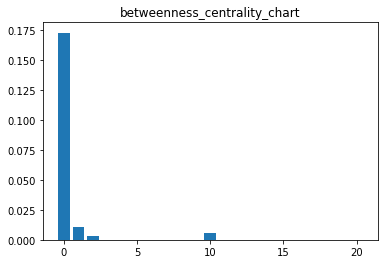

In [64]:
x_axis_locations = np.arange(data_for_chart.count()[0])
betweenness_centrality_chart = plt.bar(x_axis_locations, betweenness_centrality_for_chart,)
plt.title('betweenness_centrality_chart')
plt.show()

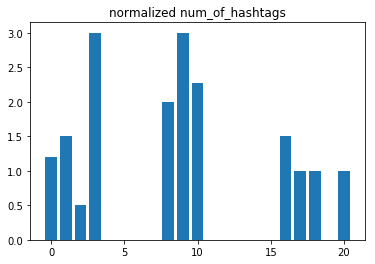

In [65]:
x_axis_locations = np.arange(data_for_chart.count()[0])
betweenness_centrality_chart = plt.bar(x_axis_locations, num_of_hashtags)
plt.title('normalized num_of_hashtags')
plt.show()

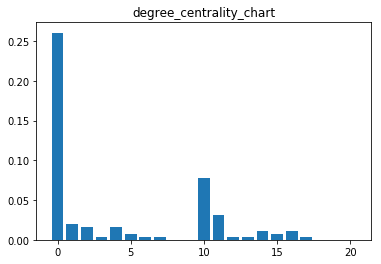

In [66]:
degree_centrality_chart= plt.bar(x_axis_locations, degree_centrality_for_chart)
plt.title('degree_centrality_chart')
plt.show()

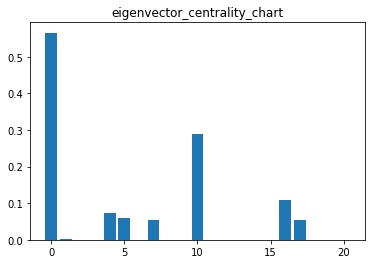

In [67]:
eigenvector_centrality_chart= plt.bar(x_axis_locations, eigenvector_centrality_for_chart)
plt.title('eigenvector_centrality_chart')
plt.show()

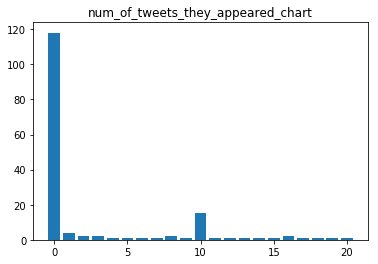

In [68]:
num_of_tweets_they_appeared_chart= plt.bar(x_axis_locations, num_of_tweets_they_appeared_for_chart)
plt.title('num_of_tweets_they_appeared_chart')
plt.show()

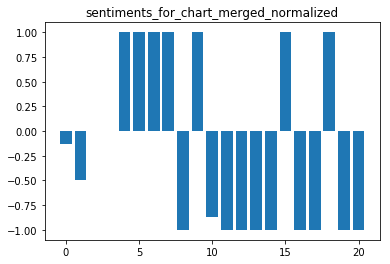

In [69]:
sentiments_for_chart_sumed_chart= plt.bar(x_axis_locations, sentiments_for_chart_merged_normalized)
plt.title('sentiments_for_chart_merged_normalized')
plt.show()

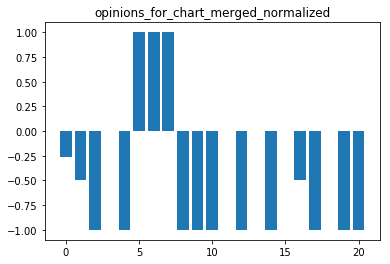

In [70]:
opinions_for_chart_sumed_chart= plt.bar(x_axis_locations,opinions_for_chart_merged_normalized)
plt.title('opinions_for_chart_merged_normalized')
plt.show()

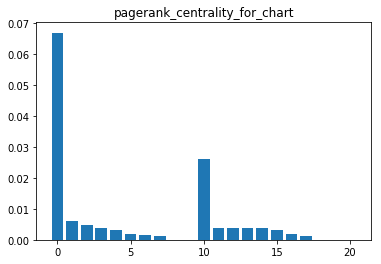

In [71]:
pagerank_chart= plt.bar(x_axis_locations,pagerank_centrality_for_chart)
plt.title('pagerank_centrality_for_chart')
plt.show()

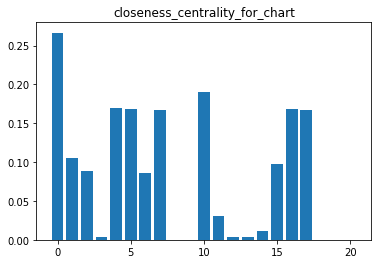

In [72]:
closeness_chart= plt.bar(x_axis_locations,closeness_centrality_for_chart)
plt.title('closeness_centrality_for_chart')
plt.show()

## After talking to my supervisor I have to change the data to help the machine learn better

## I'd rather have a row with a pair and their data instead of a single user  

In [73]:
edges = list(mention_graph.edges(data=True))
edges_in_list_form = [[i[0][1:],i[1][1:],i[2]['weight']] for i in edges]
pair_data = pd.DataFrame(edges_in_list_form, columns = ['Account1', 'Account2','Weight'])
# lower_account1= pair_data['Account1'].str.lower()
# lower_account2= pair_data['Account2'].str.lower()
# pair_data['account1'] = lower_account1
# pair_data['account2'] = lower_account2
pair_data.head()

,Account1,Account2,Weight
0,Chris_1791,newsbusters,1
1,Chris_1791,TruthRevolt,1
2,dnewhauser,GOP,1
3,GOP,spanglishpop,1
4,GOP,HillaryClinton,2


In [74]:
lookup_dataframe = df_individual_users.copy(deep = True)
lookup_dataframe.set_index("account", inplace=True)
lookup_dataframe

,target,affiliated,betweenness_centrality,degree_centrality,eigenvector_centrality,pagerank_centrality,closeness_centrality,num_of_tweets_they_appeared,sentiments,list_of_Opinion_Towards,count_hashtags
account,,,,,,,,,,,
HillaryClinton,Hillary Clinton,True,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,"[51, 67]","[43, 74, 1]","{'#world': 3, '#LibertyNotHillary': 2, '#USA':..."
billclinton,Hillary Clinton,True,0.005375,0.077821,2.899833e-01,0.026182,0.190589,14,"[0, 14]","[0, 14, 0]","{'#lol': 13, '#StopHillary2016': 11, '#WakeUpA..."
TheDemocrats,Hillary Clinton,True,0.010275,0.019455,1.183523e-03,0.006211,0.105449,4,"[1, 3]","[1, 3, 0]","{'#BlackLivesMatter': 1, '#Obama': 1, '#USA': ..."
HillaryforIA,Hillary Clinton,True,0.005092,0.027237,9.565720e-02,0.006195,0.173263,4,"[4, 0]","[4, 0, 0]","{'#world': 2, '#freedom_justice_equality_educa..."
JW4Hillary,Hillary Clinton,True,0.003465,0.015564,1.449126e-04,0.004671,0.088876,2,"[1, 1]","[0, 2, 0]",{'#Hillarymen': 1}
ClintonGlobal,Hillary Clinton,True,0.000000,0.007782,1.316940e-18,0.003876,0.007782,1,"[0, 1]","[0, 1, 0]","{'#Saudi': 1, '#SaudiCables': 2, '#clinton2016..."
ChelseaClinton,Hillary Clinton,True,0.000000,0.003891,1.030195e-23,0.003876,0.003891,2,"[1, 1]","[1, 1, 0]","{'#BillClinton': 1, '#ReadyForHillary': 1, '#H..."
HillaryforNV,Hillary Clinton,True,0.000000,0.003891,1.030195e-23,0.003876,0.003891,1,"[1, 0]","[0, 1, 0]",{'#raisethenewPOTUS': 1}
HillaryforSC,Hillary Clinton,True,0.000000,0.015564,7.439223e-02,0.003114,0.169273,1,"[1, 0]","[0, 1, 0]",{}


In [75]:
def check_if_accounts_are_affiliated(name1,name2):
    return lookup_dataframe.loc[name1]['affiliated'] and lookup_dataframe.loc[name2]['affiliated']
check_if_accounts_are_affiliated('HillaryClinton', 'billclinton')
Account1 = pair_data["Account1"].tolist()
Account2 = pair_data["Account2"].tolist()
# print(Account1)
list_affiliated = [check_if_accounts_are_affiliated(Account1[i],Account2[i]) for i in range(len(Account1))]
pair_data['both_affiliated'] = list_affiliated
pair_data

,Account1,Account2,Weight,both_affiliated
0,Chris_1791,newsbusters,1,False
1,Chris_1791,TruthRevolt,1,False
2,dnewhauser,GOP,1,False
3,GOP,spanglishpop,1,False
4,GOP,HillaryClinton,2,False
5,GOP,realDonaldTrump,1,False
6,StateDept,AmbCathyRussell,1,False
7,StateDept,AdamSmith_USA,1,False
8,StateDept,HillaryClinton,2,False
9,StateDept,HillaryforIA,1,False


In [76]:
temp = nx.edge_betweenness_centrality(mention_graph)
list_of_edge_betweenness_centrality = [temp[i] for i in temp]
pair_data['edge_betweenness_centrality'] = list_of_edge_betweenness_centrality

### Appending node data for the Account 1 

In [77]:
nodes_centralities = [
    [lookup_dataframe.loc[Account1[i]][2:10]] for i in range(len(Account1))
]
# print(nodes_centralities[0][0][0])
# print(nodes_centralities[:2])
nodes_betweenness_centrality = [
    nodes_centralities[i][0][0] for i in range(len(Account1))
]
nodes_degree_centrality = [
    nodes_centralities[i][0][1] for i in range(len(Account1))
]
nodes_eigenvector_centrality = [
    nodes_centralities[i][0][2] for i in range(len(Account1))
]
# print(nodes_eigenvector_centrality[:3])
nodes_pagerank_centrality = [nodes_centralities[i][0][3] for i in range(len(Account1))]
nodes_closeness_centrality = [nodes_centralities[i][0][4] for i in range(len(Account1))]
nodes_num_of_tweets_they_appeared = [
    nodes_centralities[i][0][5] for i in range(len(Account1))
]
nodes_sentiments_sumed = [
        nodes_centralities[i][0][6][0] - nodes_centralities[i][0][6][1]
    for i in range(len(Account1))
]
nodes_opinions_sumed = [
    nodes_centralities[i][0][7][0] - nodes_centralities[i][0][7][1]
    for i in range(len(Account1))
]
pair_data['account1_betweenness_centrality'] = nodes_betweenness_centrality
pair_data['account1_degree_centrality'] = nodes_degree_centrality
pair_data['account1_eigenvector_centrality'] = nodes_eigenvector_centrality
pair_data['account1_pagerank_centrality'] = nodes_pagerank_centrality
pair_data['account1_closeness_centrality'] = nodes_closeness_centrality
pair_data['account1_num_of_tweets_they_appeared'] = nodes_num_of_tweets_they_appeared
pair_data['account1_sentiments_sumed'] = nodes_sentiments_sumed
pair_data['account1_opinions_sumed'] = nodes_opinions_sumed
pair_data.head()


,Account1,Account2,Weight,both_affiliated,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,account1_num_of_tweets_they_appeared,account1_sentiments_sumed,account1_opinions_sumed
0,Chris_1791,newsbusters,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,2,-2,-1
1,Chris_1791,TruthRevolt,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,2,-2,-1
2,dnewhauser,GOP,1,False,0.003469,0.000000,0.003891,6.298342e-03,0.001374,0.124297,1,-1,0
3,GOP,spanglishpop,1,False,0.003469,0.006901,0.015564,6.682515e-02,0.004661,0.171530,8,-6,-5
4,GOP,HillaryClinton,2,False,0.009773,0.006901,0.015564,6.682515e-02,0.004661,0.171530,8,-6,-5


### Appending node data for the Account 2 

In [78]:
nodes_centralities = [
    [lookup_dataframe.loc[Account2[i]][2:10]] for i in range(len(Account2))
]
# print(nodes_centralities[0][0][0])
# print(nodes_centralities[:2])
nodes_betweenness_centrality = [
    nodes_centralities[i][0][0] for i in range(len(Account1))
]
nodes_degree_centrality                 = [
    nodes_centralities[i][0][1] for i in range(len(Account1))
]
nodes_eigenvector_centrality = [
    nodes_centralities[i][0][2] for i in range(len(Account1))
]
# print(nodes_eigenvector_centrality[:3])
nodes_pagerank_centrality = [nodes_centralities[i][0][3] for i in range(len(Account1))]
nodes_closeness_centrality = [nodes_centralities[i][0][4] for i in range(len(Account1))]
nodes_num_of_tweets_they_appeared = [
    nodes_centralities[i][0][5] for i in range(len(Account1))
]
nodes_sentiments_sumed = [
    nodes_centralities[i][0][6][0] - nodes_centralities[i][0][6][1]
    for i in range(len(Account1))
]
nodes_opinions_sumed = [
    nodes_centralities[i][0][7][0] - nodes_centralities[i][0][7][1]
    for i in range(len(Account1))
]

pair_data['account2_betweenness_centrality'] = nodes_betweenness_centrality
pair_data['account2_degree_centrality'] = nodes_degree_centrality
pair_data['account2_eigenvector_centrality'] = nodes_eigenvector_centrality
pair_data['account2_pagerank_centrality'] = nodes_pagerank_centrality
pair_data['account2_closeness_centrality'] = nodes_closeness_centrality
pair_data['account2_num_of_tweets_they_appeared'] = nodes_num_of_tweets_they_appeared
pair_data['account2_sentiments_sumed'] = nodes_sentiments_sumed
pair_data['account2_opinions_sumed'] = nodes_opinions_sumed
pair_data

,Account1,Account2,Weight,both_affiliated,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,...,account1_sentiments_sumed,account1_opinions_sumed,account2_betweenness_centrality,account2_degree_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account2_sentiments_sumed,account2_opinions_sumed
0,Chris_1791,newsbusters,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,...,-2,-1,0.000000,0.003891,2.064311e-21,0.002964,0.005188,1,-1,-1
1,Chris_1791,TruthRevolt,1,False,0.000060,0.000030,0.007782,2.919377e-21,0.005699,0.007782,...,-2,-1,0.000000,0.003891,2.064311e-21,0.002964,0.005188,1,-1,0
2,dnewhauser,GOP,1,False,0.003469,0.000000,0.003891,6.298342e-03,0.001374,0.124297,...,-1,0,0.006901,0.015564,6.682515e-02,0.004661,0.171530,8,-6,-5
3,GOP,spanglishpop,1,False,0.003469,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.000000,0.003891,6.298342e-03,0.001374,0.124297,1,-1,0
4,GOP,HillaryClinton,2,False,0.009773,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,-16,-31
5,GOP,realDonaldTrump,1,False,0.000452,0.006901,0.015564,6.682515e-02,0.004661,0.171530,...,-6,-5,0.007144,0.031128,1.302936e-01,0.006875,0.173848,8,-4,-2
6,StateDept,AmbCathyRussell,1,False,0.000075,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.000000,0.019455,9.313243e-02,0.003417,0.172104,1,1,1
7,StateDept,AdamSmith_USA,1,False,0.000075,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.000000,0.019455,9.313243e-02,0.003417,0.172104,1,1,1
8,StateDept,HillaryClinton,2,False,0.003092,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.172957,0.260700,5.661221e-01,0.066994,0.266628,118,-16,-31
9,StateDept,HillaryforIA,1,False,0.000189,0.000365,0.031128,1.135299e-01,0.005857,0.173848,...,0,0,0.005092,0.027237,9.565720e-02,0.006195,0.173263,4,4,4


### Making the affiliated from boolean to 0 or 1 to help the model.

In [79]:
pair_data["both_affiliated"].replace({True: 1, False: 0}, inplace=True)

### Clearing node data from nodes that apeared only once to reduce space and proobly are noise more than helpful

In [80]:
before_count = pair_data.count()[0]
pair_data = pair_data[pair_data.account2_num_of_tweets_they_appeared >1]
pair_data = pair_data[pair_data.account1_num_of_tweets_they_appeared >1]
# pair_data['Account1'] = pair_data.Account1.str.lower()
# pair_data['Account2'] = pair_data.Account2.str.lower()
# print(pair_data)
print("before it was :",before_count,"and now its : ",pair_data.count()[0])
pair_data.head()

before it was : 389 and now its :  75


,Account1,Account2,Weight,both_affiliated,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,...,account1_sentiments_sumed,account1_opinions_sumed,account2_betweenness_centrality,account2_degree_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account2_sentiments_sumed,account2_opinions_sumed
4,GOP,HillaryClinton,2,0,0.009773,0.006901,0.015564,0.066825,0.004661,0.171530,...,-6,-5,0.172957,0.260700,0.566122,0.066994,0.266628,118,-16,-31
5,GOP,realDonaldTrump,1,0,0.000452,0.006901,0.015564,0.066825,0.004661,0.171530,...,-6,-5,0.007144,0.031128,0.130294,0.006875,0.173848,8,-4,-2
8,StateDept,HillaryClinton,2,0,0.003092,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0.172957,0.260700,0.566122,0.066994,0.266628,118,-16,-31
9,StateDept,HillaryforIA,1,0,0.000189,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0.005092,0.027237,0.095657,0.006195,0.173263,4,4,4
10,StateDept,BarackObama,1,0,0.000309,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0.008816,0.046693,0.119690,0.010711,0.175628,8,4,5


### One hot encoding all hashtags: I create a set of all the hashtags and then create collumns for each account in the pair if it has that hashtags and many times.

In [81]:
list_of_dicts = []
pair_data.reset_index(drop=True, inplace=True)
Account1 = pair_data["Account1"].tolist()
Account2 = pair_data["Account2"].tolist()
for i in range(pair_data.count()[0]):
    list_of_dicts.append(lookup_dataframe.loc[Account2[i]][-1])
# print(list_of_dicts)

all_hashtags = set()
for dicti in list_of_dicts:
     for key, value in dicti.items():
            all_hashtags.add(key)
            
for i in range(pair_data.count()[0]):
    list_of_dicts.append(lookup_dataframe.loc[Account1[i]][-1])
# print(list_of_dicts)

for dicti in list_of_dicts:
     for key, value in dicti.items():
            all_hashtags.add(key)
            
list_all_hastags = list(all_hashtags)


# def count_hashtag_on_account1(hashtag):
#     return_list = []
#     for i in range(len(Account1)):
#         dict_of_account = lookup_dataframe.loc[Account1[i]][-1]
        
# def count_hashtag_on_account2(hashtag):

for hashtag in list_all_hastags:
    pair_data['account1_'+str(hashtag)] = list(itertools.repeat(0, len(Account2)))
    pair_data['account2_'+str(hashtag)] = list(itertools.repeat(0, len(Account2)))

for i in range(pair_data.count()[0]):
    acc_dict =lookup_dataframe.loc[Account1[i]][-1]
#     print(acc_dict)
    for key,value in acc_dict.items():
#         print(i)
#         print('account1_'+str(key))
        pair_data.at[i,'account1_'+str(key)] +=value
for i in range(pair_data.count()[0]):
    acc_dict =lookup_dataframe.loc[Account2[i]][-1]
#     print(acc_dict)
    for key,value in acc_dict.items():
        pair_data.at[i,'account2_'+str(key)] +=value
# pair_data.to_csv('test_csv', index=False)
pair_data.head()


,Account1,Account2,Weight,both_affiliated,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_closeness_centrality,...,account1_#NJ,account2_#NJ,account1_#Hilary,account2_#Hilary,account1_#Emails,account2_#Emails,account1_#NotAChanceInHell,account2_#NotAChanceInHell,account1_#Benghazi,account2_#Benghazi
0,GOP,HillaryClinton,2,0,0.009773,0.006901,0.015564,0.066825,0.004661,0.171530,...,0,0,0,1,0,1,0,1,0,2
1,GOP,realDonaldTrump,1,0,0.000452,0.006901,0.015564,0.066825,0.004661,0.171530,...,0,0,0,0,0,0,0,0,0,0
2,StateDept,HillaryClinton,2,0,0.003092,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0,1,0,1,0,1,0,2
3,StateDept,HillaryforIA,1,0,0.000189,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0,0,0,0,0,0,0,0
4,StateDept,BarackObama,1,0,0.000309,0.000365,0.031128,0.113530,0.005857,0.173848,...,0,0,0,0,0,0,0,0,0,0


## Time to use Feature selector to help understand the above data

### Shuffle em

In [82]:
all_data = pair_data
all_data = all_data.sample(frac=1).reset_index(drop=True)
# print(all_data.head(2))

### Creating the training data and the labels for the classification

In [83]:
train_labels = all_data['both_affiliated']
train = all_data.drop(columns = ['both_affiliated'])
fs = FeatureSelector(data = train, labels = train_labels)

### In machine learning, Collinear features lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [84]:
fs.identify_collinear(correlation_threshold=0.975 , one_hot=True)

214 features with a correlation magnitude greater than 0.97.



In [85]:
len(fs.base_features)

264

In [86]:
len(fs.one_hot_features)

63

### We found 215  features with a correlation magnitude greater than 0.97.

In [87]:
correlated_features = fs.ops['collinear']
correlated_features

['account1_degree_centrality',
 'account1_pagerank_centrality',
 'account1_num_of_tweets_they_appeared',
 'account1_opinions_sumed',
 'account2_pagerank_centrality',
 'account1_#ISIS',
 'account1_#emailgate',
 'account2_#emailgate',
 'account1_#copolitics',
 'account2_#copolitics',
 'account1_#Hillary_2016_NO',
 'account2_#Hillary_2016_NO',
 'account1_#Vote',
 'account2_#Vote',
 'account1_#Monica',
 'account2_#Monica',
 'account1_#StopLula',
 'account2_#StopLula',
 'account1_#NotReadyForHillary',
 'account2_#NotReadyForHillary',
 'account1_#Love_peace',
 'account2_#Love_peace',
 'account1_#Hanover',
 'account2_#Hanover',
 'account1_#ACUHOI',
 'account2_#ACUHOI',
 'account1_#ElizabethWarren',
 'account2_#ElizabethWarren',
 'account1_#UnstoppableTicket',
 'account2_#UnstoppableTicket',
 'account1_#PTown',
 'account2_#PTown',
 'account1_#INeedMeninist',
 'account2_#INeedMeninist',
 'account1_#wcs15',
 'account2_#wcs15',
 'account2_#PayToPlayDiplomacy',
 'account1_#RedNationRising',
 'acco

### These are the pairs for the first 5 of the above

In [88]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,account1_degree_centrality,account1_betweenness_centrality,0.976973
1,account1_pagerank_centrality,account1_degree_centrality,0.995797
2,account1_pagerank_centrality,account1_eigenvector_centrality,0.980811
3,account1_num_of_tweets_they_appeared,account1_betweenness_centrality,0.990547
4,account1_num_of_tweets_they_appeared,account1_degree_centrality,0.992364


### Searches the data for a collumn that has more than 60% missing values on it. They will not help at all.

In [89]:
fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
missing_features

0 features with greater than 0.60 missing values.



[]

### Searches the data for how many colllumns have the same value in all rows.  Which will aswell not help at all.

In [90]:
fs.identify_single_unique()

10 features with a single unique value.



In [91]:
single_unique = fs.ops['single_unique']
single_unique

['account2_#BlackLivesMatter',
 'account1_#HumaAbedin',
 'account2_#ncpol',
 'account1_#LiberalConsequences',
 'account1_#UniteBlue',
 'account2_#latinos2016',
 'account1_#ChrisChristie',
 'account2_#Rock',
 'account2_#ImCommitted2DefeatHillary',
 'account2_#SpillHill']

### Finds the number of unique values of a collumn. As you can see we dont have a collumn with 1 (checked before) 

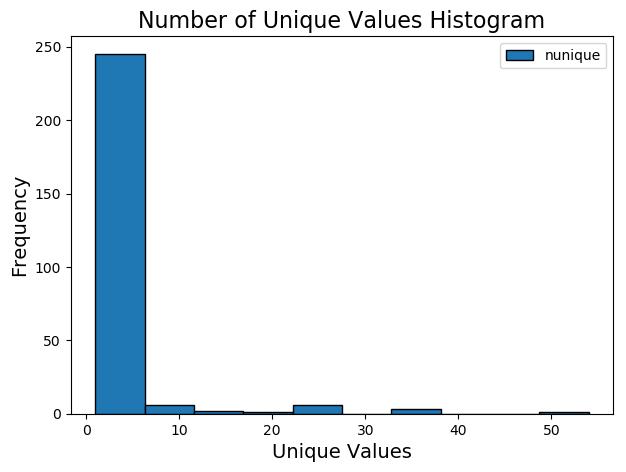

In [92]:
fs.plot_unique()

In [93]:
fs.record_collinear
# fs.remove(methods=['collinear'])

,drop_feature,corr_feature,corr_value
0,account1_degree_centrality,account1_betweenness_centrality,0.976973
1,account1_pagerank_centrality,account1_degree_centrality,0.995797
2,account1_pagerank_centrality,account1_eigenvector_centrality,0.980811
3,account1_num_of_tweets_they_appeared,account1_betweenness_centrality,0.990547
4,account1_num_of_tweets_they_appeared,account1_degree_centrality,0.992364
5,account1_num_of_tweets_they_appeared,account1_pagerank_centrality,0.981125
6,account1_opinions_sumed,account1_pagerank_centrality,-0.983747
7,account2_pagerank_centrality,account2_degree_centrality,0.980140
8,account1_#ISIS,account1_betweenness_centrality,0.993588
9,account1_#ISIS,account1_degree_centrality,0.982068


In [94]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.954545
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's auc: 0.909091
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.975
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.863636
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	val

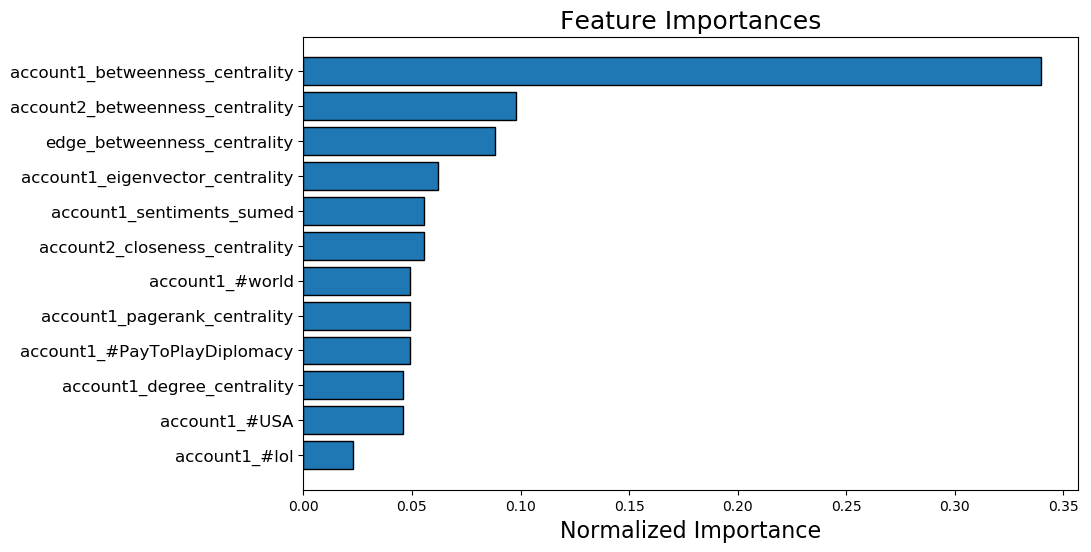

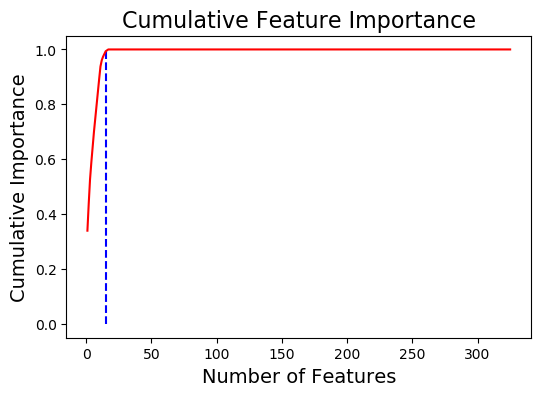

15 features required for 0.99 of cumulative importance


In [95]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)
zero_importance_features = fs.ops['zero_importance']

In [96]:
fs.identify_low_importance(cumulative_importance = 0.99)


14 features required for cumulative importance of 0.99 after one hot encoding.
311 features do not contribute to cumulative importance of 0.99.



In [97]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
one_hot_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))
print(len(base_features) + len(one_hot_features))

There are 264 original features
There are 63 one-hot features
327


In [98]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['account2_#world',
 'account2_#IaVotes',
 'account2_#ClementaPinckney',
 'account2_#LGBT',
 'account1_#ClementaPinckney',
 'account2_#iacaucus',
 'account1_#iacaucus',
 'account1_#tlot',
 'account1_#IaVotes',
 'account2_#YaaasHillary',
 'account1_#YaaasHillary',
 'account2_#ImCommitted2DefeatHillary',
 'account1_#ImCommitted2DefeatHillary',
 'account2_#Stephens',
 'account2_#tlot',
 'account1_#Stephens',
 'Weight',
 'account1_#Democrats',
 'account2_#Democrats',
 'account1_#LoveWins',
 'account2_#GayRights',
 'account1_#GayRights',
 'account2_#Clinton',
 'account1_#Clinton',
 'account2_#Corruptocrat',
 'account1_#Corruptocrat',
 'account2_#SheWhoShallNotBeNamedBecauseShesWinning',
 'account1_#SheWhoShallNotBeNamedBecauseShesWinning',
 'account2_#pervert',
 'account1_#pervert',
 'account2_#Pay2Play',
 'account1_#Pay2Play',
 'account2_#liberals',
 'account1_#liberals',
 'account1_#LGBT',
 'account2_#Greece',
 'account2_#HillaryinNH',
 'account2_#WakeUpAmerica',
 'account1_#HillaryInNH',

In [99]:
fs.feature_importances
fs.remove(methods=['zero_importance'])

Removed 308 features.


,Account1,Account2,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_num_of_tweets_they_appeared,account1_sentiments_sumed,account2_betweenness_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account1_#USA,account1_#PayToPlayDiplomacy,account1_#lol,account1_#world,account1_#Benghazi
0,GOP,realDonaldTrump,0.000452,0.006901,0.015564,6.682515e-02,0.004661,8,-6,0.007144,1.302936e-01,0.006875,0.173848,8,0,0,0,0,0
1,NRO,johnpodesta,0.010225,0.006870,0.011673,5.176534e-03,0.004172,2,0,0.010214,5.384548e-02,0.002311,0.170961,2,0,0,0,0,0
2,JoeBiden,SenSanders,0.003288,0.000000,0.011673,1.199143e-03,0.003021,2,-2,0.022982,1.028733e-02,0.005237,0.140984,2,0,0,0,0,0
3,HillaryClinton,Babbsgirl2,0.028756,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.031919,1.090612e-01,0.002824,0.180558,2,1,1,13,3,2
4,jstines3,larryelder,0.001475,0.006347,0.027237,8.374296e-02,0.005658,3,-3,0.000000,2.265206e-02,0.002558,0.126435,2,0,0,0,0,0
5,StateDept,HillaryforIA,0.000189,0.000365,0.031128,1.135299e-01,0.005857,2,0,0.005092,9.565720e-02,0.006195,0.173263,4,0,1,0,1,0
6,billclinton,POTUS,0.000030,0.005375,0.077821,2.899833e-01,0.026182,14,-14,0.005375,2.899833e-01,0.026182,0.190589,15,0,0,13,0,0
7,HillaryClinton,politico,0.008023,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.006901,1.215410e-01,0.006073,0.172104,6,1,1,13,3,2
8,HillaryClinton,WoodenThreat,0.005288,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.003988,1.339425e-01,0.004655,0.172682,2,1,1,13,3,2
9,WoodenThreat,ProudInfidel33,0.000160,0.003988,0.027237,1.339425e-01,0.004655,2,-2,0.000040,1.459887e-01,0.005090,0.171530,2,0,0,1,0,0


### A feature with only one unique value cannot be useful for machine learning because this feature has zero variance. So lets remove it.

In [100]:

fs.remove(methods=['single_unique'])

Removed 10 features.


,Account1_BarackObama,Account1_BernieSanders,Account1_BretBaier,Account1_DrMartyFox,Account1_FoxNews,Account1_GOP,Account1_GovChristie,Account1_HillaryClinton,Account1_HillaryforIA,Account1_JoeBiden,...,account1_#NJ,account2_#NJ,account1_#Hilary,account2_#Hilary,account1_#Emails,account2_#Emails,account1_#NotAChanceInHell,account2_#NotAChanceInHell,account1_#Benghazi,account2_#Benghazi
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,2,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,2,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
new_data = fs.remove(methods=['single_unique','zero_importance'])
new_data['labels'] = fs.labels
new_data

Removed 308 features.


,Account1,Account2,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_num_of_tweets_they_appeared,account1_sentiments_sumed,account2_betweenness_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account1_#USA,account1_#PayToPlayDiplomacy,account1_#lol,account1_#world,account1_#Benghazi,labels
0,GOP,realDonaldTrump,0.000452,0.006901,0.015564,6.682515e-02,0.004661,8,-6,0.007144,1.302936e-01,0.006875,0.173848,8,0,0,0,0,0,0
1,NRO,johnpodesta,0.010225,0.006870,0.011673,5.176534e-03,0.004172,2,0,0.010214,5.384548e-02,0.002311,0.170961,2,0,0,0,0,0,0
2,JoeBiden,SenSanders,0.003288,0.000000,0.011673,1.199143e-03,0.003021,2,-2,0.022982,1.028733e-02,0.005237,0.140984,2,0,0,0,0,0,0
3,HillaryClinton,Babbsgirl2,0.028756,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.031919,1.090612e-01,0.002824,0.180558,2,1,1,13,3,2,0
4,jstines3,larryelder,0.001475,0.006347,0.027237,8.374296e-02,0.005658,3,-3,0.000000,2.265206e-02,0.002558,0.126435,2,0,0,0,0,0,0
5,StateDept,HillaryforIA,0.000189,0.000365,0.031128,1.135299e-01,0.005857,2,0,0.005092,9.565720e-02,0.006195,0.173263,4,0,1,0,1,0,0
6,billclinton,POTUS,0.000030,0.005375,0.077821,2.899833e-01,0.026182,14,-14,0.005375,2.899833e-01,0.026182,0.190589,15,0,0,13,0,0,0
7,HillaryClinton,politico,0.008023,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.006901,1.215410e-01,0.006073,0.172104,6,1,1,13,3,2,0
8,HillaryClinton,WoodenThreat,0.005288,0.172957,0.260700,5.661221e-01,0.066994,118,-16,0.003988,1.339425e-01,0.004655,0.172682,2,1,1,13,3,2,0
9,WoodenThreat,ProudInfidel33,0.000160,0.003988,0.027237,1.339425e-01,0.004655,2,-2,0.000040,1.459887e-01,0.005090,0.171530,2,0,0,1,0,0,0


In [102]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from numpy import random
min_max_scaler = preprocessing.MinMaxScaler()
trans = new_data.loc[:,"edge_betweenness_centrality" : "labels"]
labels_for_trans = trans.columns
x_scaled = min_max_scaler.fit_transform(trans)
norm_data = pd.DataFrame(x_scaled,columns=labels_for_trans)
norm_data

,edge_betweenness_centrality,account1_betweenness_centrality,account1_degree_centrality,account1_eigenvector_centrality,account1_pagerank_centrality,account1_num_of_tweets_they_appeared,account1_sentiments_sumed,account2_betweenness_centrality,account2_eigenvector_centrality,account2_pagerank_centrality,account2_closeness_centrality,account2_num_of_tweets_they_appeared,account1_#USA,account1_#PayToPlayDiplomacy,account1_#lol,account1_#world,account1_#Benghazi,labels
0,0.009288,0.039897,0.045455,1.180402e-01,0.040843,0.051724,0.50,0.041303,2.301511e-01,0.087243,0.646874,0.051724,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.209907,0.039722,0.030303,9.143847e-03,0.033321,0.000000,0.80,0.059055,9.511284e-02,0.017953,0.635882,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.067492,0.000000,0.030303,2.118170e-03,0.015598,0.000000,0.70,0.132874,1.817157e-02,0.062365,0.521788,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.590299,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.00,0.184547,1.926461e-01,0.025730,0.672412,0.000000,1.0,1.0,1.000000,0.6,1.0,0.0
4,0.030279,0.036699,0.090909,1.479239e-01,0.056176,0.008621,0.65,0.000000,4.001268e-02,0.021702,0.466415,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.003870,0.002109,0.106061,2.005396e-01,0.059244,0.000000,0.80,0.029440,1.689692e-01,0.076917,0.644646,0.017241,0.0,1.0,0.000000,0.2,0.0,0.0
6,0.000619,0.031074,0.287879,5.122275e-01,0.371996,0.103448,0.10,0.031074,5.122275e-01,0.380368,0.710591,0.112069,0.0,0.0,1.000000,0.0,0.0,0.0
7,0.164706,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.00,0.039897,2.146905e-01,0.075070,0.640235,0.034483,1.0,1.0,1.000000,0.6,1.0,0.0
8,0.108545,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.00,0.023060,2.365964e-01,0.053528,0.642433,0.000000,1.0,1.0,1.000000,0.6,1.0,0.0
9,0.003282,0.023060,0.090909,2.365964e-01,0.040741,0.000000,0.70,0.000228,2.578750e-01,0.060133,0.638051,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0


In [103]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(norm_data, 0.2)
print(len(train_set), "train +", len(test_set), "test")
print(train_set)

60 train + 15 test
    edge_betweenness_centrality  account1_betweenness_centrality  \
22                     0.045820                         1.000000   
5                      0.003870                         0.002109   
33                     0.109804                         1.000000   
56                     0.222136                         1.000000   
66                     0.013829                         0.031074   
39                     0.003715                         0.000000   
40                     0.020743                         0.039897   
16                     0.007740                         0.031074   
44                     0.003715                         0.039897   
45                     0.013829                         0.031074   
30                     0.277399                         1.000000   
7                      0.164706                         1.000000   
58                     0.003715                         0.000703   
47                     0.0153

In [104]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
X_train  = train_set.loc[:,"edge_betweenness_centrality" : "account1_#world"]
# print(X_train)
y_train  = train_set.loc[:,"labels"]
# print(y_train)
X_test  = test_set.loc[:,"edge_betweenness_centrality" : "account1_#world"]
# print(X_train)
y_test  = test_set.loc[:,"labels"]
# print(y_train)

sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train, y_train)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

array([0.9047619 , 0.95      , 0.94736842])

In [105]:
from sklearn.base import BaseEstimator

class NeverTrueClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_clf = NeverTrueClassifier()
cross_val_score(never_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.95, 0.95, 0.9 ])

## Time to make the above runnable and create a database to store the tweets I get and retrive them to process them

### Disclaimer: The below have been ran in Pycharm because they work woth databeses and Runnable codes. That means below you will have the codes themselves but commented to see what was eunning when I was collectiong and storing tweets. \

In [106]:
# import copy

import pymongo
# import tweepy
# from Twitter_crawler import twitter_credentials

### A twitter listener that listens to the recent tweets and if they contain the query ... In our case Donald Trump or his other aliases then it saves the to  a database. In the same time as you can see on the on_status method. Which is the function I follow if I hit a match. I get the json format of the tweet .

In [107]:
#         fields_i_want = ["id", "text", "entities"]
#         entities_fields = ["hashtags", "user_mentions"]
#         counter = 0

#         class MyStreamListener(tweepy.StreamListener):
#             def __init__(self):
#                 super().__init__()
#                 self.counter = 0

#             def on_status(self, status):
#                 status = status._json
#                 # temp = copy.deepcopy(status)
#                 # for i in status:
#                 #     if str(i) not in fields_i_want:
#                 #         del temp[i]
#                 # for i in status["entities"]:
#                 #     if str(i) not in entities_fields:
#                 #         del temp["entities"][i]
#                 # for i in range(len(status["entities"]['user_mentions'])):
#                 #     del temp["entities"]['user_mentions'][i]['indices']
#                 #     del temp["entities"]['user_mentions'][i]['id_str']
#                 #     try:
#                 #         temp["entities"]['user_mentions'][i]['follower_count'] = api.get_user(
#                 #             temp["entities"]['user_mentions'][i]["id"]).followers_count
#                 #     except tweepy.error.TweepError:
#                 #         temp["entities"]['user_mentions'][i]['follower_count'] = None
#                 status["_id"] = status.pop('id')
#                 if not mycol.count_documents({"_id": status["_id"]}):
#                     mycol.insert_one(status)
#                     self.counter += 1
#                     print("count : ", self.counter)
#                     current_tweets = mycol.estimated_document_count()
#                     print("current tweets are : ", current_tweets)
#                     if max_tweets < current_tweets:
#                         exit(0)

#             def on_error(self, status_code):
#                 if status_code == 420:
#                     # returning False in on_error disconnects the stream
#                     return False

### Here is the process tha is runnning and the thing you should know is that sometimes the connection fails for uknown reasons so the continue resets the program so it never stops appending to the database. 
### It is working perfectly

In [108]:
# while True:
#     try:
#         # Authenticate to Twitter
#         auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
#         auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)

#         api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#         query = ["Donald Trump", "@realDonaldTrump", "Donald J. Trump"]

#         max_tweets = 100000

#         connection = pymongo.MongoClient("localhost", 27017)
#         db = connection["Affiliated_DB"]
#         mycol = db["testing"]

        
#         print("initializing listener")
#         myStreamListener = MyStreamListener()
#         myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener, tweet_mode='extended')

#         myStream.filter(track=query)
#     except:
#         continue

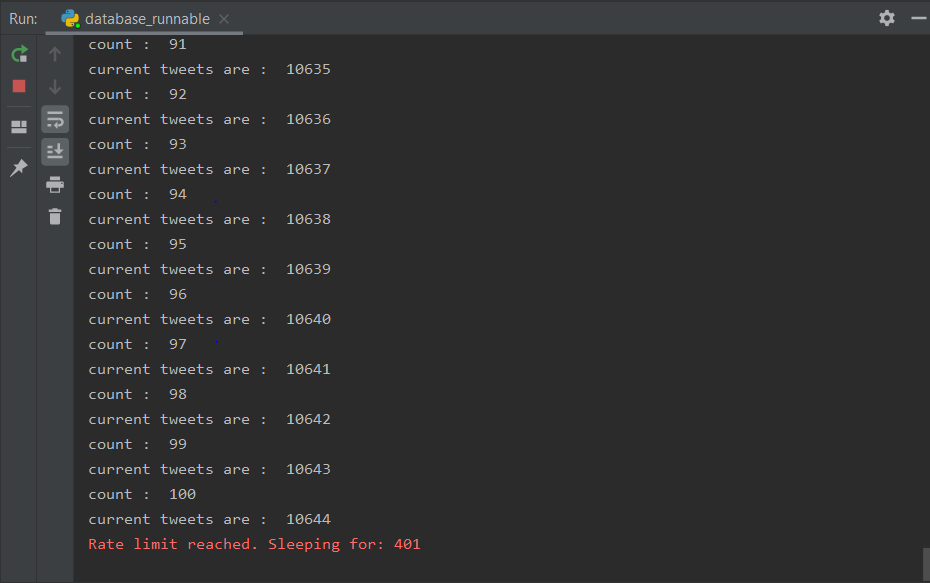

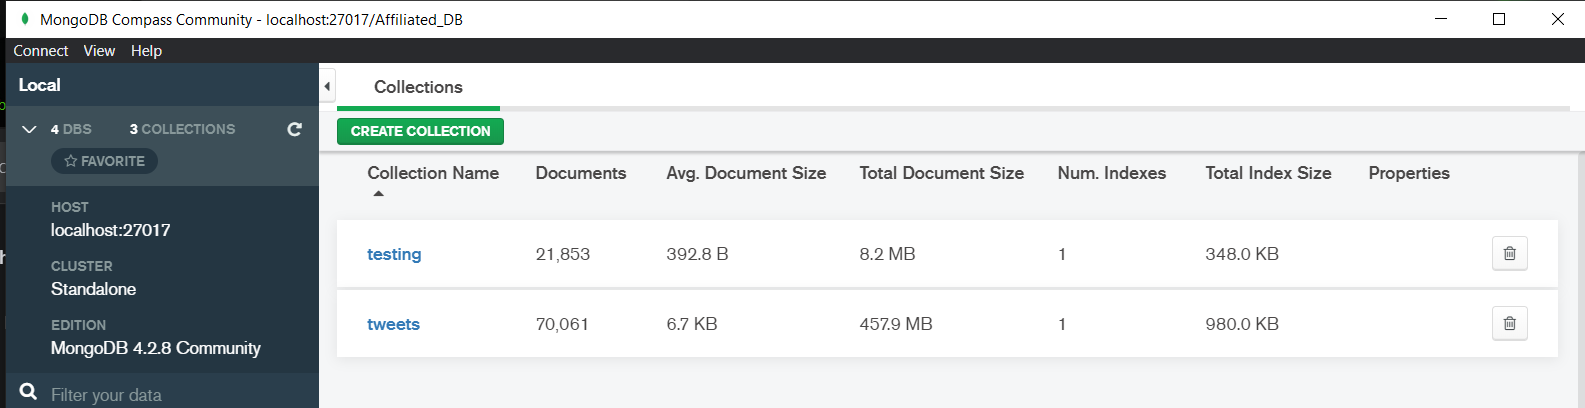

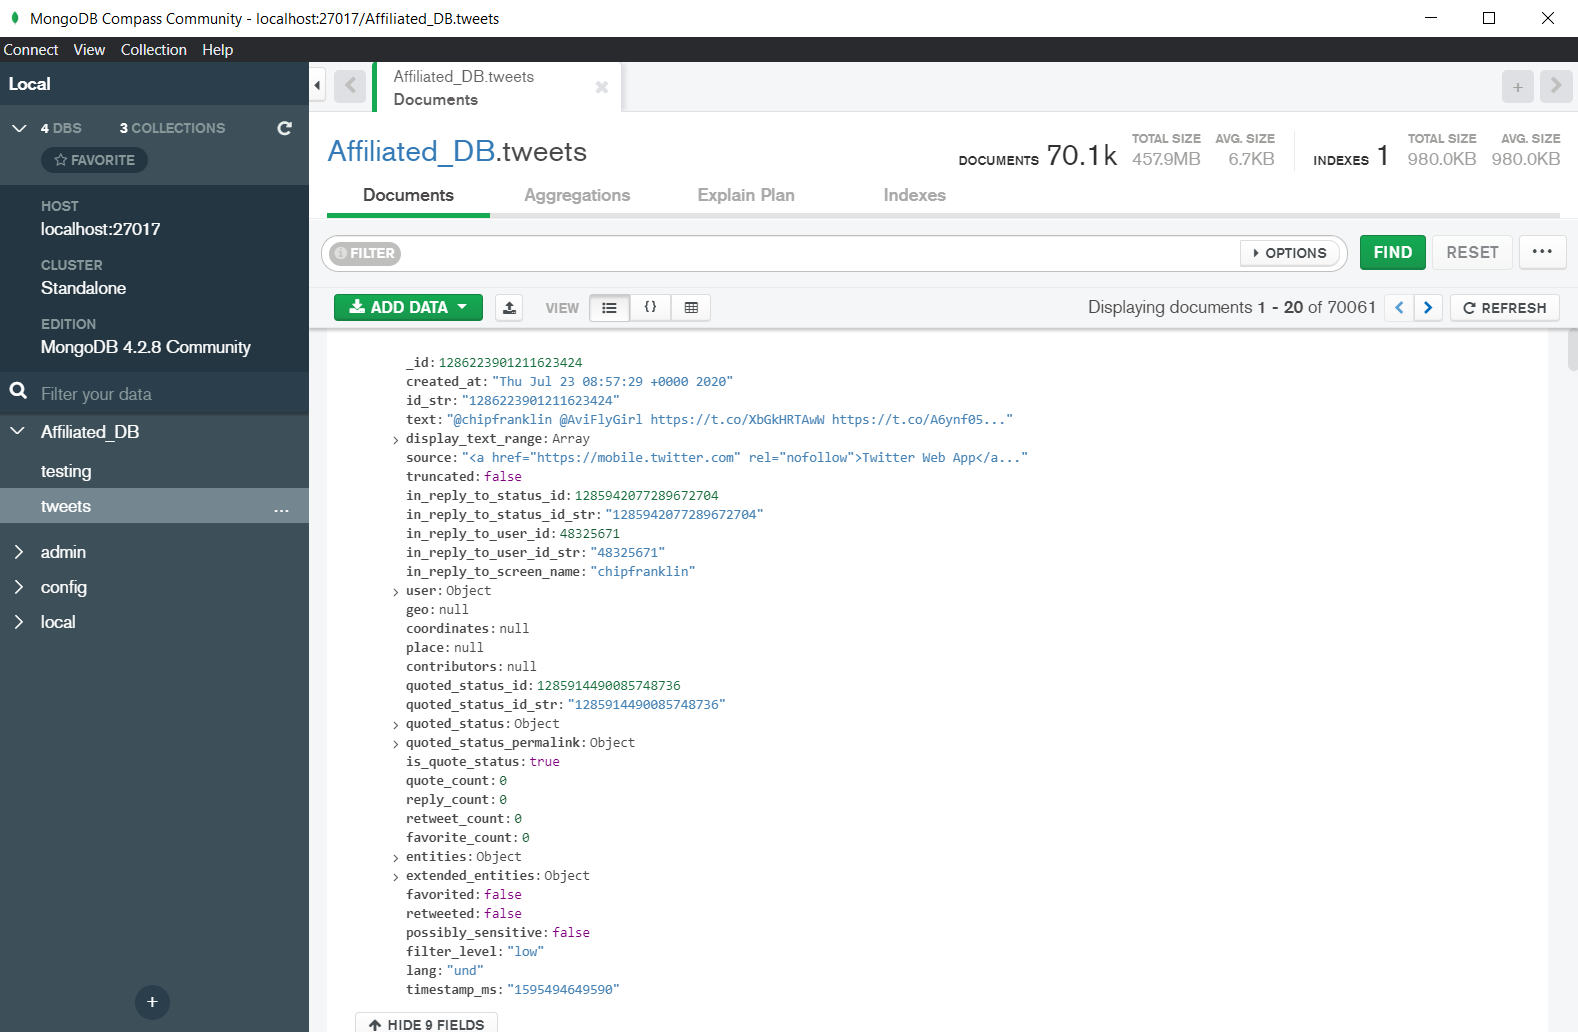

In [109]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["Affiliated_DB"]
mycol = mydb["testing"]


In [110]:
import pprint
tweets = mycol.find()
for i in tweets[:3]:
    pprint.pprint(i)

{'_id': 1285227206256582659,
 'entities': {'hashtags': [],
              'user_mentions': [{'follower_count': 35116,
                                 'id': 1270704242718846978,
                                 'name': '🇺🇸🍺🇺🇸Sean USMCSDI 🇺🇸🍺🇺🇸',
                                 'screen_name': 'PISDI0331'},
                                {'follower_count': 7080808,
                                 'id': 939091,
                                 'name': 'Joe Biden',
                                 'screen_name': 'JoeBiden'}]},
 'text': 'RT @PISDI0331: @JoeBiden Yep\n\nThat would be DONALD J. TRUMP 2020'}
{'_id': 1285227206289969152,
 'entities': {'hashtags': [{'indices': [53, 67], 'text': 'MondayMorning'},
                           {'indices': [68, 79], 'text': 'MondayMood'},
                           {'indices': [100, 111], 'text': 'KidVicious'}],
              'user_mentions': [{'follower_count': 164722,
                                 'id': 164060400,
                              

In [111]:
dict_of_tweets ={}
for i in mycol.find():
    dict_of_tweets[i["_id"]] = {'entities': i['entities'], 'text': i['text']   }
dict_of_tweets

{1285227206256582659: {'entities': {'hashtags': [],
   'user_mentions': [{'screen_name': 'PISDI0331',
     'name': '🇺🇸🍺🇺🇸Sean USMCSDI 🇺🇸🍺🇺🇸',
     'id': 1270704242718846978,
     'follower_count': 35116},
    {'screen_name': 'JoeBiden',
     'name': 'Joe Biden',
     'id': 939091,
     'follower_count': 7080808}]},
  'text': 'RT @PISDI0331: @JoeBiden Yep\n\nThat would be DONALD J. TRUMP 2020'},
 1285227206289969152: {'entities': {'hashtags': [{'text': 'MondayMorning',
     'indices': [53, 67]},
    {'text': 'MondayMood', 'indices': [68, 79]},
    {'text': 'KidVicious', 'indices': [100, 111]}],
   'user_mentions': [{'screen_name': 'kirkacevedo',
     'name': 'kirk acevedo',
     'id': 164060400,
     'follower_count': 164722},
    {'screen_name': 'realDonaldTrump',
     'name': 'Donald J. Trump',
     'id': 25073877,
     'follower_count': 83830477}]},
  'text': 'RT @kirkacevedo: I heard this book was pretty good!\n\n#MondayMorning\n#MondayMood🔪\n@realDonaldTrump \n\n#KidVicious😏 https:

In [112]:
#     if print_it:
#         pos = nx.spring_layout(G)  # positions for all nodes
#         nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")
#         nx.draw(G, pos)
#         labels = nx.get_edge_attributes(G, "weight")
#         nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
#         plt.show()
#     return G
Donald_Trump_Graph = nx.Graph()
for key, value in dict_of_tweets.items():
    tweet = value
    entities = tweet["entities"]["user_mentions"]
    name_of_users = [i["name"] for i in entities]
    screen_names = [i["screen_name"] for i in entities]
    num_of_hashtags = len(tweet["entities"]["hashtags"])
    followers = [i["follower_count"] for i in entities]
    user_ids = [i["id"] for i in entities]

    for pair in itertools.combinations(name_of_users, 2):
        entity = pair[0]
        entity_secondary = pair[1]
        if Donald_Trump_Graph.has_edge(entity, entity_secondary):
            Donald_Trump_Graph.add_edge(
                entity,
                entity_secondary,
                weight=Donald_Trump_Graph[entity][entity_secondary]["weight"] + 1,
            )
        else:
            Donald_Trump_Graph.add_edge(entity, entity_secondary, weight=1)
    if len(name_of_users)>=2:
        for i in range(len(name_of_users)):
            Donald_Trump_Graph.node[name_of_users[i]]["screen_name"] = screen_names[i]
            try: 
                 Donald_Trump_Graph.node[name_of_users[i]]["num_of_hashtags"] = (
                    Donald_Trump_Graph.node[name_of_users[i]]["num_of_hashtags"]
                    + num_of_hashtags)
            except KeyError:
                   Donald_Trump_Graph.node[name_of_users[i]]["num_of_hashtags"] =num_of_hashtags  

            Donald_Trump_Graph.node[name_of_users[i]]["followers"] = followers[i]
            Donald_Trump_Graph.node[name_of_users[i]]["id"] = user_ids[i]
            
print(Donald_Trump_Graph.nodes["Donald J. Trump"])
ayy = nx.all_neighbors(Donald_Trump_Graph, "Donald J. Trump")
ayy = [i for i in ayy]
print(len(ayy))
print(ayy)


{'screen_name': 'realDonaldTrump', 'num_of_hashtags': 1355, 'followers': 83938344, 'id': 25073877}
6139
['kirk acevedo', 'Tom Fitton', 'P  V ❤️🇺🇸TRUMP❤️🇺🇸', '𝔸𝕩𝕖𝕝𝕣𝕠𝕕 🛥🇺🇸', 'Jean L.P. Jaurès 🌎🔬📚⚖️', 'Allen West', 'Diana Wright', 'I am Publius', 'Charlie Daniels', 'Pam Sands 🇺🇸⭐️⭐️⭐️⭐️🇺🇸', 'NANCY', '𝓙𝓸💋𝓞𝓷 𝓣𝓱𝓮 (𝓡)𝓲𝓰𝓱𝓽™ ⭐️⭐️⭐️', 'Mayor Ted Wheeler', '⚜ şᶤ𝖊𝖗𝖗𝐚 𝖜ђᶤş𝖐𝖊𝖊™ 🇺🇸🕇𝖐n𝖊𝖊l to J𝖊şuş', 'stuart stevens', 'Vincent Caldarola🇺🇸', "TRUMP'S SILENT MAJORITY!", '𝕊𝕜𝕪', 'Cheryl Miller', 'Jo', '𝕮𝖍𝖗𝖎𝖘𝖙𝖎𝖓𝖆 ℭ𝔞𝔯𝔯𝔢𝔯𝔞', 'Leah Le Q', 'Ted Cruz', 'Kat  #ISTANDWITHGENFLYNN', 'GOP', 'Jorge Suarez-Velez', 'BardsFM 🇺🇸', 'Melania Trump', 'President Trump', 'DieBurger', 'Maroela Media', 'Terrence K. Williams', 'Pedro Frazão 🇵🇹🇺🇸', 'Rafael Moreira 🇵🇹🇪🇺', 'Patrick Nova', 'patricia lundy', 'Washington Examiner', 'Fox News', 'Michael Rogero', 'jen pal', 'newtgingrich', 'Define Projection', 'RD', 'The Lincoln Project', 'Team Trump (Text TRUMP to 88022)', 'Dr. Dena Grayson', 'UMA', 'Vice President Mike Pence', 'Secret

In [113]:
for node in Donald_Trump_Graph.nodes(data = True):
    print(node)

('🇺🇸🍺🇺🇸Sean USMCSDI 🇺🇸🍺🇺🇸', {'screen_name': 'PISDI0331', 'num_of_hashtags': 0, 'followers': 35175, 'id': 1270704242718846978})
('Joe Biden', {'screen_name': 'JoeBiden', 'num_of_hashtags': 50, 'followers': 7153521, 'id': 939091})
('kirk acevedo', {'screen_name': 'kirkacevedo', 'num_of_hashtags': 6, 'followers': 164939, 'id': 164060400})
('Donald J. Trump', {'screen_name': 'realDonaldTrump', 'num_of_hashtags': 1355, 'followers': 83938344, 'id': 25073877})
('Tom Fitton', {'screen_name': 'TomFitton', 'num_of_hashtags': 12, 'followers': 1092098, 'id': 18266688})
('P  V ❤️🇺🇸TRUMP❤️🇺🇸', {'screen_name': 'PVTrump', 'num_of_hashtags': 6, 'followers': 51857, 'id': 470468291})
('𝔸𝕩𝕖𝕝𝕣𝕠𝕕 🛥🇺🇸', {'screen_name': 'RealDealAxelrod', 'num_of_hashtags': 0, 'followers': 113886, 'id': 820808196956655616})
('Lybio✏️⭐️🇺🇸MAGA💪📒🌎🌐📝🇨🇦💻', {'screen_name': 'Lybio', 'num_of_hashtags': 0, 'followers': 41627, 'id': 17022502})
('Vice President Mike Pence', {'screen_name': 'VP', 'num_of_hashtags': 25, 'followers': 93040

('Bret Baier', {'screen_name': 'BretBaier', 'num_of_hashtags': 0, 'followers': 1417644, 'id': 18646108})
('vampireonpills', {'screen_name': 'vampireonpills', 'num_of_hashtags': 2, 'followers': 40, 'id': 1232587621873831936})
('CrazyB🇺🇸ConservaShe', {'screen_name': 'TrumpYourDaddy', 'num_of_hashtags': 0, 'followers': 44, 'id': 1240633665039761408})
('American Supporter', {'screen_name': 'bestlotionsdeal', 'num_of_hashtags': 0, 'followers': 191, 'id': 1220813971})
('🇺🇸AmyCia🇺🇸', {'screen_name': 'AmyCia1', 'num_of_hashtags': 0, 'followers': 88, 'id': 1087083804668375040})
('C🇺🇸H🇺🇸U🇺🇸C🇺🇸K', {'screen_name': 'Charles33359581', 'num_of_hashtags': 0, 'followers': 3786, 'id': 1182383442564132865})
('GilgameshMa_PG', {'screen_name': 'GilgameshMa', 'num_of_hashtags': 0, 'followers': 24, 'id': 3068977923})
('Joshua', {'screen_name': 'H3chtic1589', 'num_of_hashtags': 0, 'followers': 42, 'id': 540021094})
('Better Angels of Our Nature', {'screen_name': 'MommaB3r1', 'num_of_hashtags': 0, 'followers':

('a chickensexual pan', {'screen_name': 'coffeebbeen', 'num_of_hashtags': 0, 'followers': 22, 'id': 1244489570537869315})
('DigitSoldi3r', {'screen_name': 'DigitSoldi3r', 'num_of_hashtags': 0, 'followers': 1, 'id': 1282732006267334656})
('Suzanne Humphries', {'screen_name': 'DrsuzanneH', 'num_of_hashtags': 0, 'followers': 5172, 'id': 706375255376293888})
('Mistress of Hell', {'screen_name': 'Hellmistress1', 'num_of_hashtags': 0, 'followers': 619, 'id': 992515442538352641})
('ConservativeMOMom', {'screen_name': 'mrsmaisy', 'num_of_hashtags': 0, 'followers': 7327, 'id': 42228475})
('Biden2020', {'screen_name': 'Eddy46295688', 'num_of_hashtags': 0, 'followers': 24, 'id': 1274353723549126656})
('Alain Bo', {'screen_name': 'agbinfo', 'num_of_hashtags': 0, 'followers': 72, 'id': 1276466293})
('Darryl D (DEEP STATE Warrior)', {'screen_name': 'OregonDarryl', 'num_of_hashtags': 0, 'followers': 7587, 'id': 244347285})
('🌸 Pink Lady 4 Trump 🌸', {'screen_name': 'pink_lady56', 'num_of_hashtags': 0,

('DatFROMAN', {'screen_name': 'thatfromanshow', 'num_of_hashtags': 0, 'followers': 5439, 'id': 1356036962})
("What part of NO don't you democrat's understand !!", {'screen_name': 'misterhite1', 'num_of_hashtags': 0, 'followers': 10069, 'id': 724407363277590528})
('NorthernGirl', {'screen_name': 'UpNorthinAk', 'num_of_hashtags': 0, 'followers': 10933, 'id': 929974377789001729})
('Gary Walters', {'screen_name': 'GaryWalters66', 'num_of_hashtags': 0, 'followers': 53181, 'id': 980486140334616576})
('Donagmc18', {'screen_name': 'donagmc18', 'num_of_hashtags': 0, 'followers': 2493, 'id': 1280998068335378432})
('Alison - Hello, NATO?', {'screen_name': 'jankybrain', 'num_of_hashtags': 0, 'followers': 9741, 'id': 17496621})
("Lincoln's Bible", {'screen_name': 'LincolnsBible', 'num_of_hashtags': 0, 'followers': 135731, 'id': 536904693})
('Richard W. Painter', {'screen_name': 'RWPUSA', 'num_of_hashtags': 0, 'followers': 720524, 'id': 2863996955})
('Sendbad Bahri', {'screen_name': 'sendbadbahri', 

('eddy', {'screen_name': 'Eddy46295688', 'num_of_hashtags': 0, 'followers': 24, 'id': 1274353723549126656})
('Tim “dad as a doornail” ONeill', {'screen_name': 'oh_birdwatchers', 'num_of_hashtags': 0, 'followers': 204, 'id': 387314024})
('Q The Wake Up', {'screen_name': 'QTheWakeUp', 'num_of_hashtags': 0, 'followers': 135350, 'id': 48473072})
('QNN: Qanon News Network', {'screen_name': 'realQNN', 'num_of_hashtags': 0, 'followers': 40055, 'id': 4117810553})
('Txbigfut', {'screen_name': 'txbigfut', 'num_of_hashtags': 0, 'followers': 4, 'id': 1170892208473616385})
('🌻🐘\U0001f973🇺🇸 Wescyde 🎉\U0001f9e8🎊🌠', {'screen_name': 'Hardcastle1971', 'num_of_hashtags': 0, 'followers': 389, 'id': 788832764351119364})
('🇳🇬Isa🔻', {'screen_name': 'Beli_198', 'num_of_hashtags': 0, 'followers': 172, 'id': 274205947})
('FromTexasInNewJersey', {'screen_name': 'Texas21542413', 'num_of_hashtags': 0, 'followers': 564, 'id': 1309013910})
('bamajeans⭐⭐⭐', {'screen_name': 'BamaJeans24', 'num_of_hashtags': 0, 'follow

In [114]:
betweeness_centr = nx.betweenness_centrality(Donald_Trump_Graph)
betweeness_centr

{'🇺🇸🍺🇺🇸Sean USMCSDI 🇺🇸🍺🇺🇸': 0.0,
 'Joe Biden': 0.008566105639472958,
 'kirk acevedo': 0.0,
 'Donald J. Trump': 0.8262493627632455,
 'Tom Fitton': 0.0004741954917722494,
 'P  V ❤️🇺🇸TRUMP❤️🇺🇸': 0.0,
 '𝔸𝕩𝕖𝕝𝕣𝕠𝕕 🛥🇺🇸': 0.0003408269599574219,
 'Lybio✏️⭐️🇺🇸MAGA💪📒🌎🌐📝🇨🇦💻': 2.6236906901240287e-09,
 'Vice President Mike Pence': 0.0007509804412098774,
 'Mike Pence': 2.7416839579790473e-05,
 'Reliable Sources': 0.0,
 'David Zurawik': 0.0,
 'Sarah Cooper': 0.0004861697087358526,
 'The Lincoln Project': 0.003329069575242006,
 'Jean L.P. Jaurès 🌎🔬📚⚖️': 6.821595794322473e-08,
 'Allen West': 0.0008863431107828259,
 'Diana Wright': 0.0,
 'I am Publius': 0.0,
 'Charlie Daniels': 0.0,
 'Pam Sands 🇺🇸⭐️⭐️⭐️⭐️🇺🇸': 3.410797897161237e-08,
 'NANCY': 0.00024097287143444153,
 '𝓙𝓸💋𝓞𝓷 𝓣𝓱𝓮 (𝓡)𝓲𝓰𝓱𝓽™ ⭐️⭐️⭐️': 6.45615316248377e-08,
 'Mayor Ted Wheeler': 0.00011485391643374018,
 'Jali_Cat{⭐️}': 0.0003033966995364085,
 'Evangelist Alveda King': 0.0,
 'Larry Elder': 0.0003111973366012397,
 'Mike Tyson': 0.0,
 'Terrell Owens